In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from math import sqrt
import random

<h2>Utils</h2>

In [4]:
def retrieve_mean_std(dataset):
    mean_sum = 0
    std_sum = 0
    total_pixel = 0

    for img, label in dataset:
        img = transforms.ToTensor()(img)
        mean_sum = mean_sum + torch.sum(img[:, :])
        total_pixel = total_pixel+img.shape[1] * img.shape[2] 

    mean = mean_sum / total_pixel

    for img, label in dataset:
        img = transforms.ToTensor()(img)
        std_sum = std_sum + torch.sum((img[:, :] - mean) ** 2)
        total_pixel = total_pixel + img.shape[1] * img.shape[2]

    std = torch.sqrt(std_sum / total_pixel)
    return mean, std

In [120]:
def get_model_size(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()

    size_all_mb = (param_size + buffer_size) / 1024**2
    return '{:.3f}MB'.format(size_all_mb)

In [122]:
def show_models_sizes(backbones):
    model_sizes = []

    for backbone in backbones:
        model = get_model(backbone)
        model_sizes.append(get_model_size(model))

    return pd.DataFrame({'Backbone': backbones,
                         'Model size': model_sizes})

In [14]:
def plot_metrics(train_losses, val_losses, val_metrics, metric_name):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.plot(val_metrics, label=f'Val {metric_name}')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name)
    plt.title(f'Training and Validation {metric_name}')
    plt.legend()
    plt.savefig(f'{metric_name}_plot.png')
    plt.show()

<h2>Dataset</h2>

In [3]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data.iloc[idx, 0])
        image = Image.open(img_name)
        scores = np.hstack(self.data.iloc[idx, 1:].values).astype(np.float32)
        scores = torch.from_numpy(scores)
        if self.transform:
            image = self.transform(image)
        return image, scores

In [5]:
csv_file='../data/car_imgs_4000.csv'
root_dir='../data/imgs'

In [6]:
dataset = CustomDataset(csv_file=csv_file,
                        root_dir=root_dir,
                        transform=None)
mean, std = retrieve_mean_std(dataset)

In [7]:
class ApplyNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        return transforms.Normalize((self.mean, ), (self.std, ))(tensor)


    def __repr__(self):
        return f"{self.__class__.__name__} (mean={self.mean}, std={self.std})"
    
class AdjustSharpness(object):
    def __init__(self,  sharpness_factor=None, p=0.25):
        self.sharpness_factor = sharpness_factor
        self.p = p

    def __call__(self, tensor):
        if random.random() < self.p:
            if not self.sharpness_factor:
                sharpness_factor = random.uniform(0.5, 1.5)
            return transforms.functional.adjust_sharpness(tensor,
                                                          self.sharpness_factor)
        else:
            return tensor

    def __repr__(self):
        repr_str = (f"{self.__class__.__name__} "
                    + f"(sharpness_factor={self.sharpness_factor})")
        return repr_str
    
class AdjustBrightness(object):
    def __init__(self, brightness_factor=None, p=0.25):
        self.brightness_factor = brightness_factor
        self.p = p

    def __call__(self, tensor):
        if random.random() < self.p:
            brightness_factor = self.brightness_factor
            if not brightness_factor:
                brightness_factor = random.uniform(0.6, 1.4)
            return transforms.functional.adjust_brightness(tensor,
                                                           self.brightness_factor)
        else:
            return tensor

    def __repr__(self):
        repr_str = (f"{self.__class__.__name__} "
                    + f"(brightness_factor={self.brightness_factor})")
        return repr_str


In [8]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    ApplyNormalize(mean=mean,
                  std=std),
    AdjustSharpness(),
    AdjustBrightness(),
])

# Load dataset and split into train/validation/test
dataset = CustomDataset(csv_file=csv_file,
                        root_dir=root_dir,
                        transform=transform)

train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

In [9]:
batch_size = 16

In [32]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

<h2>Models</h2>

In [54]:
class ResnetsRegressionModel(nn.Module):
    def __init__(self, backbone, pretrained=True):
        super(ResnetsRegressionModel, self).__init__()
        # Load pre-trained resnets model
        self.backbone = backbone
        if backbone == "resnet18":
            self.model = models.resnet18(pretrained=pretrained)
        elif backbone == "resnet34":
            self.model = models.resnet34(pretrained=pretrained)
        elif backbone == "resnet50":
            self.model = models.resnet50(pretrained=pretrained)

        # Freeze the parameters so they are not updated during training
        for param in self.model.parameters():
            param.requires_grad = False
        # Modify the last fully connected layer for regression
        self.model.fc = nn.Sequential(
            nn.Linear(self.model.fc.in_features, 256),
            nn.ReLU(),
            nn.Linear(256, 2),  
            nn.Sigmoid()  
        )

    def forward(self, x):
        return self.model(x)

class EfficientnetsRegressionModel(nn.Module):
    def __init__(self, backbone, pretrained=True):
        super(EfficientnetsRegressionModel, self).__init__()
        # Load pre-trained model
        self.backbone = backbone
        if backbone == "efficientnet_b0":
            self.model = models.efficientnet_b0(pretrained=pretrained)
        elif backbone == "efficientnet_b1":
            self.model = models.efficientnet_b1(pretrained=pretrained)
        elif backbone == "efficientnet_b2":
            self.model = models.efficientnet_b2(pretrained=pretrained)
        elif backbone == "efficientnet_b3":
            self.model = models.efficientnet_b3(pretrained=pretrained)

        # Freeze the parameters so they are not updated during training
        for param in self.model.parameters():
            param.requires_grad = False
            
        # Modify the last classifier for regression
        self.model.classifier = nn.Sequential(
            nn.Linear(self.model.classifier[1].in_features, 256),
            nn.ReLU(),
            nn.Linear(256, 2),  
            nn.Sigmoid()  
        )

    def forward(self, x):
        return self.model(x)
    
class InceptionRegressionModel(nn.Module):
    def __init__(self, pretrained=True):
        super(InceptionRegressionModel, self).__init__()
        # Load pre-trained  model
        self.backbone = "inception_v3"
        self.model = models.googlenet(pretrained=pretrained)
        # Freeze the parameters so they are not updated during training
        for param in self.model.parameters():
            param.requires_grad = False
        # Modify the last fully connected layer for regression
        self.model.fc = nn.Sequential(
            nn.Linear(self.model.fc.in_features, 256),
            nn.ReLU(),
            nn.Linear(256, 2),  
            nn.Sigmoid()  
        )

    def forward(self, x):
        return self.model(x)
    
class VisionTransformersRegressionModel(nn.Module):
    def __init__(self, backbone, pretrained=True):
        super(VisionTransformersRegressionModel, self).__init__()
        # Load pre-trained model
        self.backbone = backbone
        if backbone == "vit_b_16":
            self.model = models.vit_b_16(pretrained=pretrained)

        elif backbone == "vit_h_14":
            self.model = models.vit_h_14(pretrained=pretrained)

        # Freeze the parameters so they are not updated during training
        for param in self.model.parameters():
            param.requires_grad = False
        # Modify the last fully connected layer for regression
        self.model.heads = nn.Sequential(
            nn.Linear(self.model.heads.head.in_features, 256),
            nn.ReLU(),
            nn.Linear(256, 2),  # Output 2 values for regression
            nn.Sigmoid()  # Sigmoid activation to ensure values between 0 and 1
        )

    def forward(self, x):
        return self.model(x)

def get_model(backbone):
    # ======= Resnets =====================================
    if backbone in ["resnet18", "resnet34", "resnet50"]:
        return ResnetsRegressionModel(backbone)
    # ======= Efficientnets =====================================
    elif backbone in ["efficientnet_b0", "efficientnet_b1", "efficientnet_b2", "efficientnet_b3"]:
        return EfficientnetsRegressionModel(backbone)

    # ============= inception_v3 ============================
    elif backbone=="inception_v3":
        return InceptionRegressionModel()

    # ============= Vision Transform ============================
    elif backbone in ["vit_b_16", "vit_h_14"]:
        return VisionTransformersRegressionModel(backbone)
    
    else:
        return 

<h4>Show model sizes</h4>

In [125]:
backbones = ["resnet18", "resnet34", "resnet50", 
             "efficientnet_b0", "efficientnet_b1", "efficientnet_b2", "efficientnet_b3", 
             "inception_v3", 
             "vit_b_16"]
show_models_sizes(backbones)

,Backbone,Model size
0,resnet18,43.175MB
1,resnet34,81.763MB
2,resnet50,91.882MB
3,efficientnet_b0,16.701MB
4,efficientnet_b1,26.336MB
5,efficientnet_b2,31.013MB
6,efficientnet_b3,42.639MB
7,inception_v3,22.421MB
8,vit_b_16,328.049MB


<h2>Training</h2>

In [12]:
def train_step(model, criterion, optimizer, epochs, train_loader, val_loader):
    train_losses = []
    val_losses = []
    val_mses = []
    val_maes = []
    val_rmses = []
    val_r2s = []

    # Training loop
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        
        # Validation
        model.eval()
        val_loss = 0.0
        val_predictions = []
        val_labels = []
        with torch.no_grad():
            for data in val_loader:
                inputs, labels = data
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
                val_predictions.extend(outputs.numpy())
                val_labels.extend(labels.numpy())
            val_loss /= len(val_loader)
            val_losses.append(val_loss)

            # Calculate validation metrics
            val_predictions = np.array(val_predictions)
            val_labels = np.array(val_labels)
            val_mse = mean_squared_error(val_labels, val_predictions)
            val_mae = mean_absolute_error(val_labels, val_predictions)
            val_rmse = sqrt(val_mse)
            val_r2 = r2_score(val_labels, val_predictions)
            val_mses.append(val_mse)
            val_maes.append(val_mae)
            val_rmses.append(val_rmse)
            val_r2s.append(val_r2)

        print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.3f}, Val Loss: {val_loss:.3f}')
        print('VAL MSE: %.3f, MAE: %.3f, RMSE: %.3f, R-squared: %.3f' % (val_mse, val_mae, val_rmse, val_r2))


    print('Finished Training')
    return model, train_losses, val_losses, val_mses, val_maes, val_rmses, val_r2s

<h2>Random Grid Seach</h2>

In [55]:
def random_grid_search(backbone, grid_params, num_iterations, train_loader, val_loader):
    print(f'[{backbone}]: Start Random Grid Search', )
    best_model = None
    best_mse = float('inf')
    best_epoch = 0

    for iteration in range(num_iterations):
        # Sample hyperparameters randomly
        params = {param_name: random.choice(param_values) for param_name, param_values in grid_params.items()}
        print(f'Iteration [{iteration}], Params: {params}')
        # Initialize model, optimizer, and criterion with sampled hyperparameters
        model = get_model(backbone)
        optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
        criterion = nn.MSELoss()

        # Train the model
        model, train_losses, val_losses, val_mses, val_maes, val_rmses, val_r2s = train_step(model,
                                                                                             criterion,
                                                                                             optimizer,
                                                                                             params['epochs'],
                                                                                             train_loader,
                                                                                             val_loader,
                                                                                             )

        # Plot and save training and validation metrics
        plot_metrics(train_losses, val_losses, val_mses, backbone + '_MSE')
        plot_metrics(train_losses, val_losses, val_maes, backbone + '_MAE')
        plot_metrics(train_losses, val_losses, val_rmses, backbone + '_RMSE')
        plot_metrics(train_losses, val_losses, val_r2s, backbone + '_R-squared')
        
        # Evaluate on validation set
        val_mse = val_mses[-1]  # MSE from the last epoch

        # Save model if it improves MSE
        if val_mse < best_mse:
            best_model = model
            best_mse = val_mse
            best_epoch = len(train_losses)

    return best_model, best_mse, best_epoch

[resnet18]: Start Random Grid Search
Iteration [0], Params: {'learning_rate': 0.0001, 'epochs': 10}
Epoch [1/10], Train Loss: 0.108, Val Loss: 0.080
VAL MSE: 0.080, MAE: 0.242, RMSE: 0.283, R-squared: 0.384
Epoch [2/10], Train Loss: 0.078, Val Loss: 0.063
VAL MSE: 0.063, MAE: 0.200, RMSE: 0.251, R-squared: 0.509
Epoch [3/10], Train Loss: 0.067, Val Loss: 0.061
VAL MSE: 0.061, MAE: 0.192, RMSE: 0.246, R-squared: 0.525
Epoch [4/10], Train Loss: 0.062, Val Loss: 0.059
VAL MSE: 0.059, MAE: 0.181, RMSE: 0.242, R-squared: 0.538
Epoch [5/10], Train Loss: 0.060, Val Loss: 0.056
VAL MSE: 0.056, MAE: 0.173, RMSE: 0.236, R-squared: 0.564
Epoch [6/10], Train Loss: 0.056, Val Loss: 0.054
VAL MSE: 0.054, MAE: 0.165, RMSE: 0.233, R-squared: 0.574
Epoch [7/10], Train Loss: 0.056, Val Loss: 0.054
VAL MSE: 0.054, MAE: 0.169, RMSE: 0.232, R-squared: 0.576
Epoch [8/10], Train Loss: 0.056, Val Loss: 0.052
VAL MSE: 0.052, MAE: 0.161, RMSE: 0.227, R-squared: 0.593
Epoch [9/10], Train Loss: 0.053, Val Loss: 0

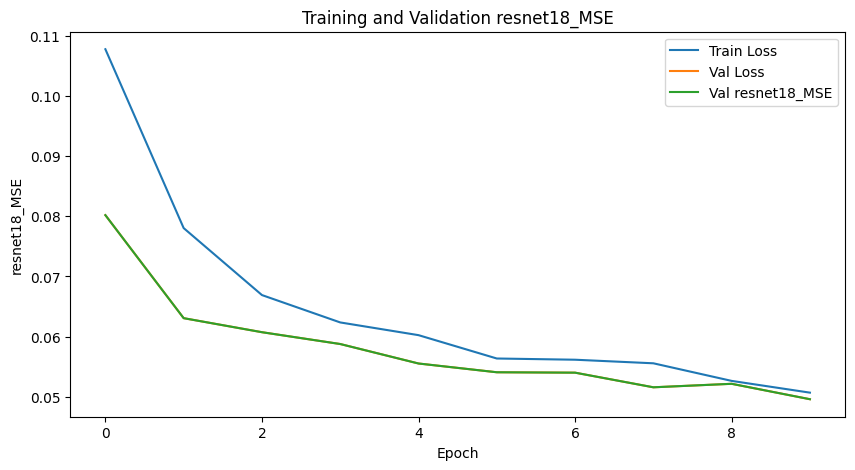

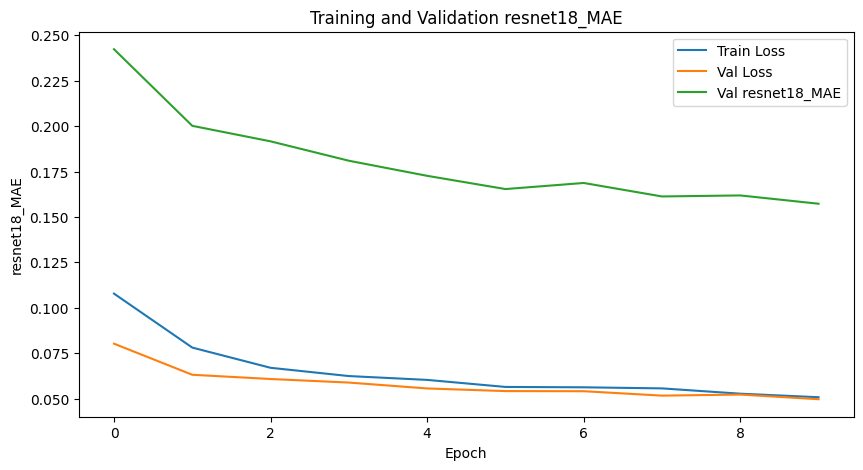

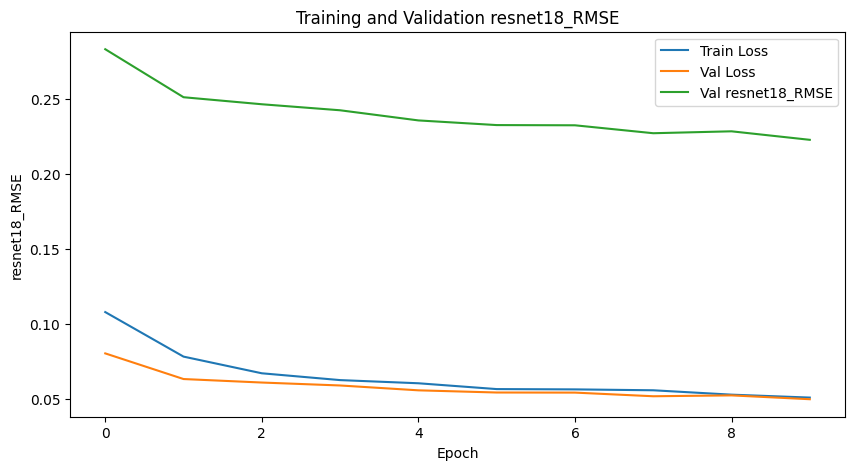

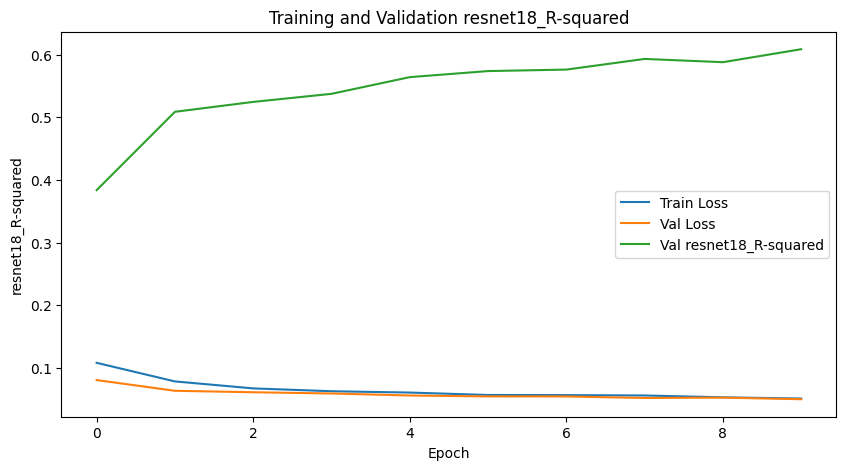

Iteration [1], Params: {'learning_rate': 0.0001, 'epochs': 5}
Epoch [1/5], Train Loss: 0.110, Val Loss: 0.077
VAL MSE: 0.077, MAE: 0.238, RMSE: 0.277, R-squared: 0.409
Epoch [2/5], Train Loss: 0.078, Val Loss: 0.063
VAL MSE: 0.063, MAE: 0.203, RMSE: 0.252, R-squared: 0.507
Epoch [3/5], Train Loss: 0.067, Val Loss: 0.059
VAL MSE: 0.059, MAE: 0.188, RMSE: 0.242, R-squared: 0.541
Epoch [4/5], Train Loss: 0.064, Val Loss: 0.056
VAL MSE: 0.056, MAE: 0.178, RMSE: 0.237, R-squared: 0.561
Epoch [5/5], Train Loss: 0.061, Val Loss: 0.056
VAL MSE: 0.056, MAE: 0.179, RMSE: 0.238, R-squared: 0.558
Finished Training


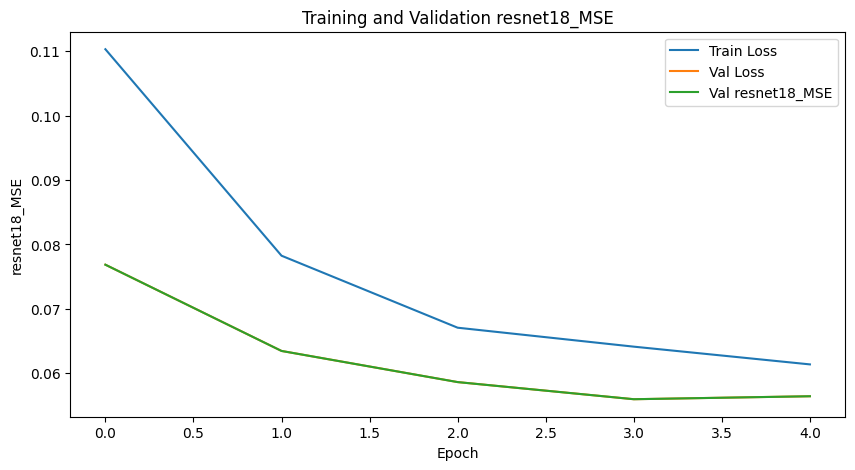

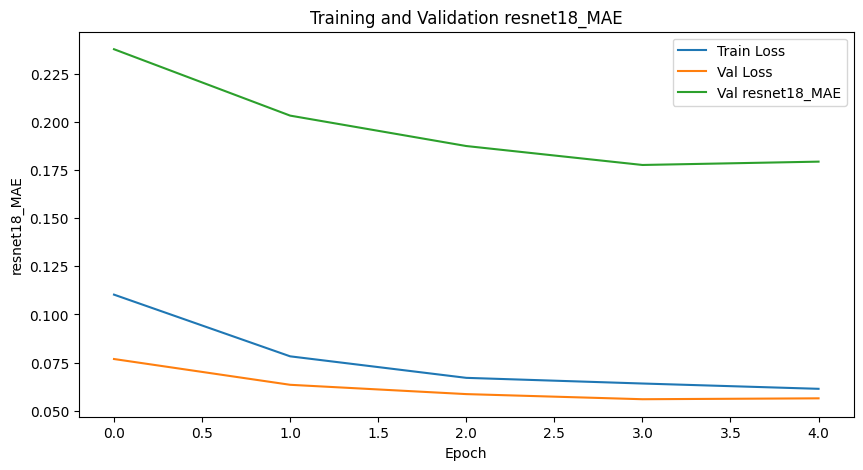

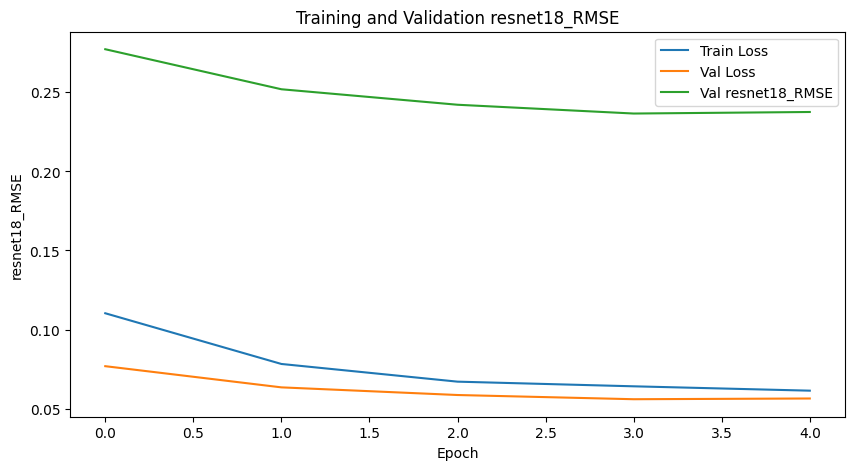

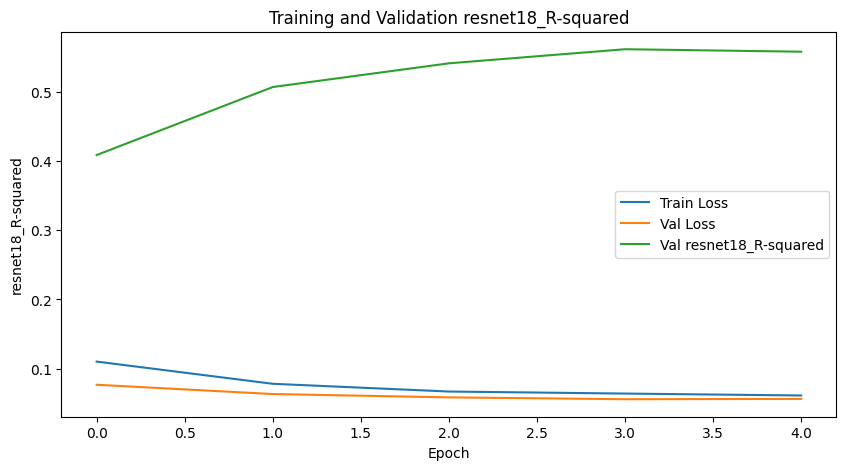

Iteration [2], Params: {'learning_rate': 0.0001, 'epochs': 10}
Epoch [1/10], Train Loss: 0.109, Val Loss: 0.077
VAL MSE: 0.077, MAE: 0.235, RMSE: 0.277, R-squared: 0.411
Epoch [2/10], Train Loss: 0.077, Val Loss: 0.066
VAL MSE: 0.066, MAE: 0.208, RMSE: 0.258, R-squared: 0.487
Epoch [3/10], Train Loss: 0.067, Val Loss: 0.058
VAL MSE: 0.058, MAE: 0.181, RMSE: 0.241, R-squared: 0.545
Epoch [4/10], Train Loss: 0.064, Val Loss: 0.057
VAL MSE: 0.057, MAE: 0.180, RMSE: 0.239, R-squared: 0.552
Epoch [5/10], Train Loss: 0.061, Val Loss: 0.054
VAL MSE: 0.054, MAE: 0.171, RMSE: 0.232, R-squared: 0.577
Epoch [6/10], Train Loss: 0.057, Val Loss: 0.054
VAL MSE: 0.054, MAE: 0.166, RMSE: 0.232, R-squared: 0.575
Epoch [7/10], Train Loss: 0.056, Val Loss: 0.053
VAL MSE: 0.053, MAE: 0.163, RMSE: 0.230, R-squared: 0.581
Epoch [8/10], Train Loss: 0.054, Val Loss: 0.051
VAL MSE: 0.051, MAE: 0.160, RMSE: 0.225, R-squared: 0.601
Epoch [9/10], Train Loss: 0.052, Val Loss: 0.051
VAL MSE: 0.051, MAE: 0.160, RMSE

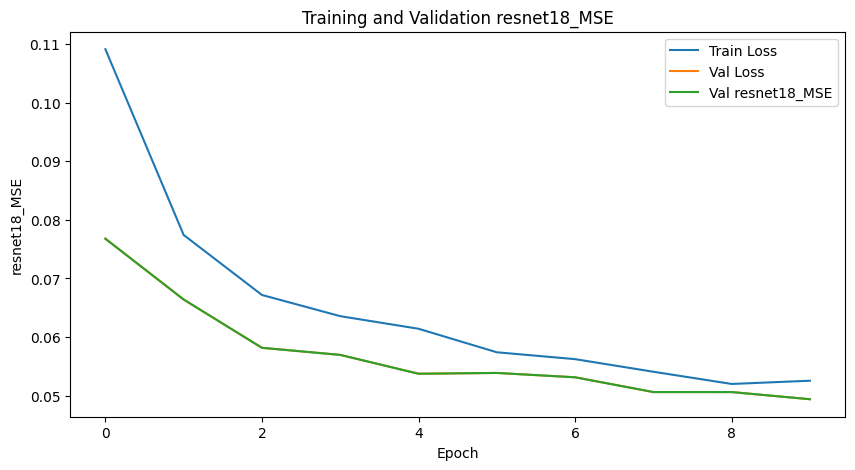

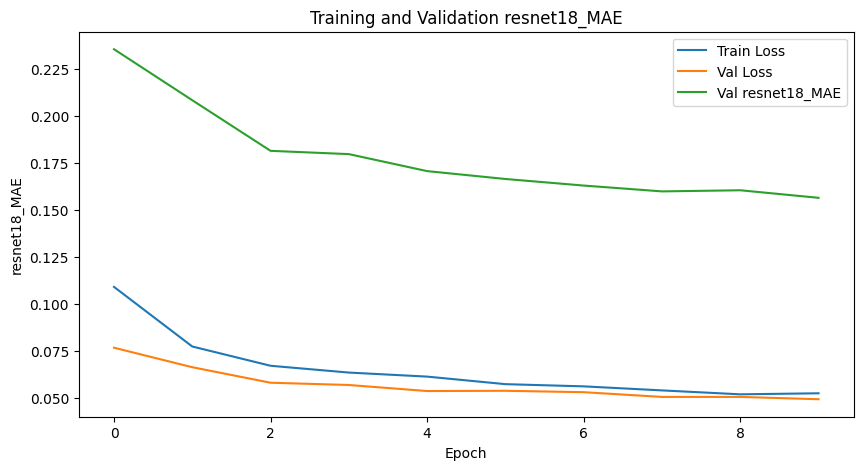

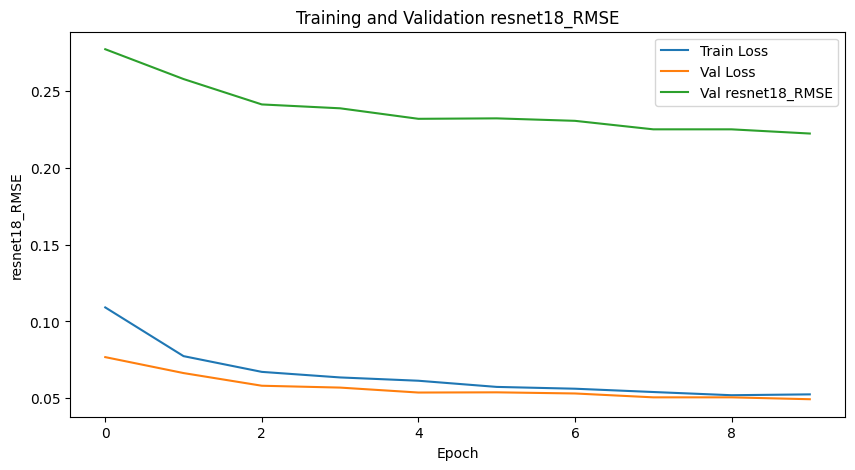

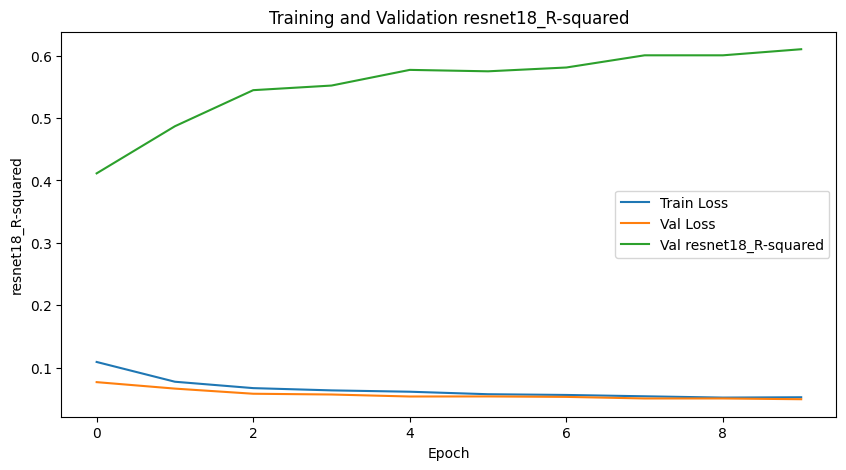

Iteration [3], Params: {'learning_rate': 0.001, 'epochs': 10}
Epoch [1/10], Train Loss: 0.087, Val Loss: 0.057
VAL MSE: 0.057, MAE: 0.173, RMSE: 0.239, R-squared: 0.554
Epoch [2/10], Train Loss: 0.065, Val Loss: 0.054
VAL MSE: 0.054, MAE: 0.160, RMSE: 0.232, R-squared: 0.574
Epoch [3/10], Train Loss: 0.059, Val Loss: 0.055
VAL MSE: 0.055, MAE: 0.166, RMSE: 0.236, R-squared: 0.564
Epoch [4/10], Train Loss: 0.055, Val Loss: 0.048
VAL MSE: 0.048, MAE: 0.150, RMSE: 0.219, R-squared: 0.620
Epoch [5/10], Train Loss: 0.050, Val Loss: 0.043
VAL MSE: 0.043, MAE: 0.136, RMSE: 0.207, R-squared: 0.662
Epoch [6/10], Train Loss: 0.047, Val Loss: 0.050
VAL MSE: 0.050, MAE: 0.152, RMSE: 0.223, R-squared: 0.614
Epoch [7/10], Train Loss: 0.041, Val Loss: 0.040
VAL MSE: 0.040, MAE: 0.129, RMSE: 0.200, R-squared: 0.686
Epoch [8/10], Train Loss: 0.037, Val Loss: 0.043
VAL MSE: 0.043, MAE: 0.132, RMSE: 0.207, R-squared: 0.665
Epoch [9/10], Train Loss: 0.038, Val Loss: 0.046
VAL MSE: 0.046, MAE: 0.134, RMSE:

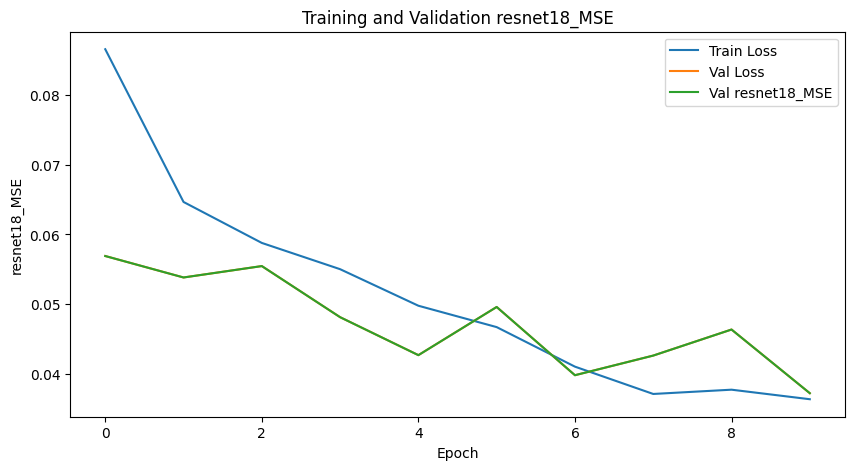

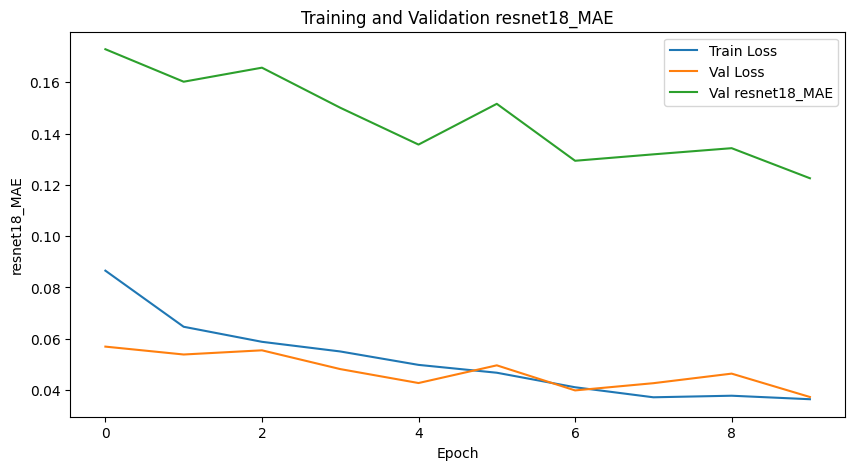

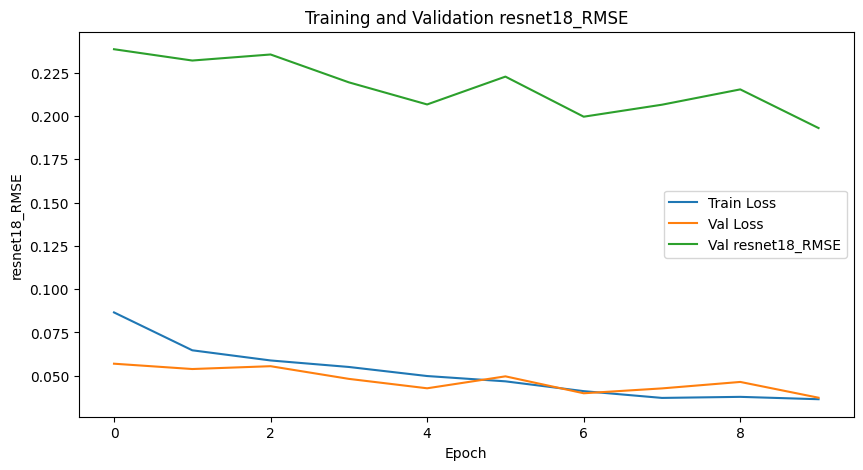

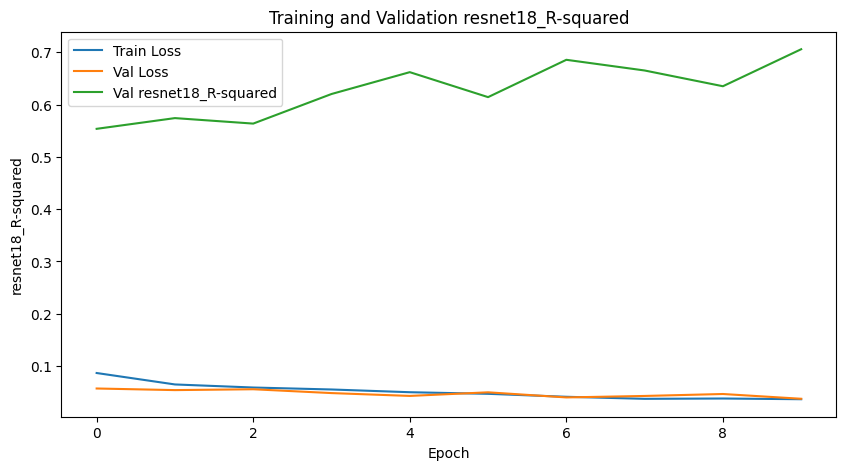

Best model saved with MSE: 0.0372597798705101 at epoch 10 with backbone resnet18
--------------------------------------------------
[inception_v3]: Start Random Grid Search
Iteration [0], Params: {'learning_rate': 0.0001, 'epochs': 5}
Epoch [1/5], Train Loss: 0.117, Val Loss: 0.085
VAL MSE: 0.085, MAE: 0.257, RMSE: 0.291, R-squared: 0.349
Epoch [2/5], Train Loss: 0.088, Val Loss: 0.069
VAL MSE: 0.069, MAE: 0.216, RMSE: 0.262, R-squared: 0.466
Epoch [3/5], Train Loss: 0.078, Val Loss: 0.068
VAL MSE: 0.068, MAE: 0.205, RMSE: 0.260, R-squared: 0.470
Epoch [4/5], Train Loss: 0.075, Val Loss: 0.061
VAL MSE: 0.061, MAE: 0.190, RMSE: 0.246, R-squared: 0.527
Epoch [5/5], Train Loss: 0.072, Val Loss: 0.061
VAL MSE: 0.061, MAE: 0.187, RMSE: 0.247, R-squared: 0.525
Finished Training


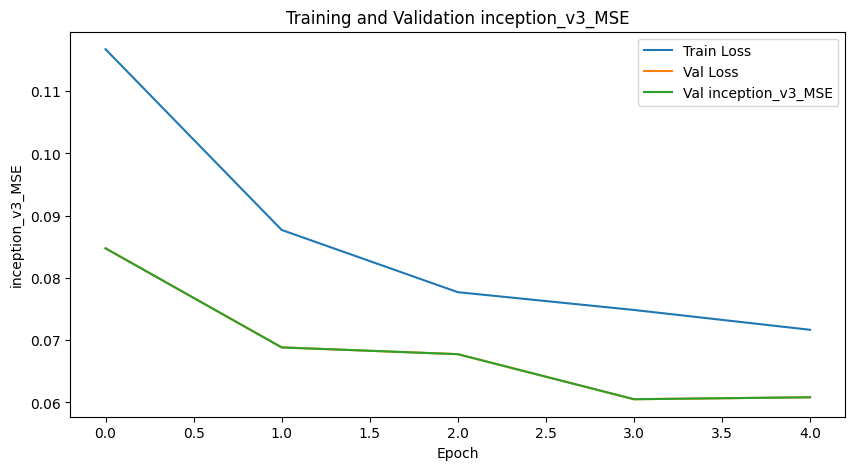

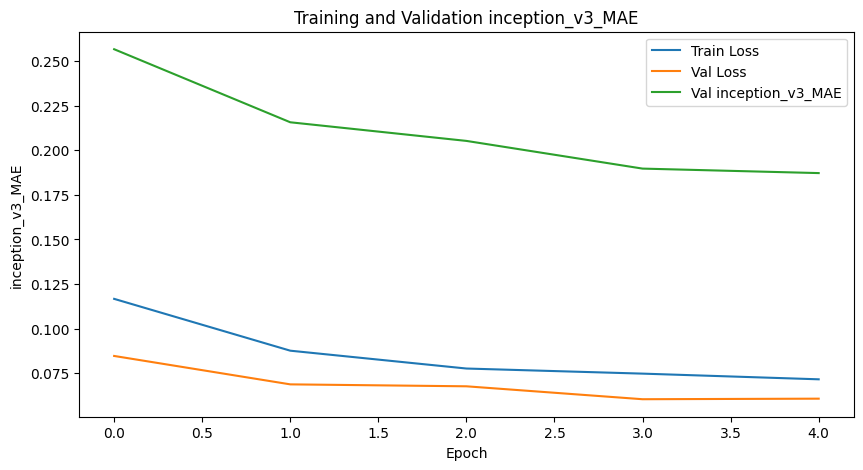

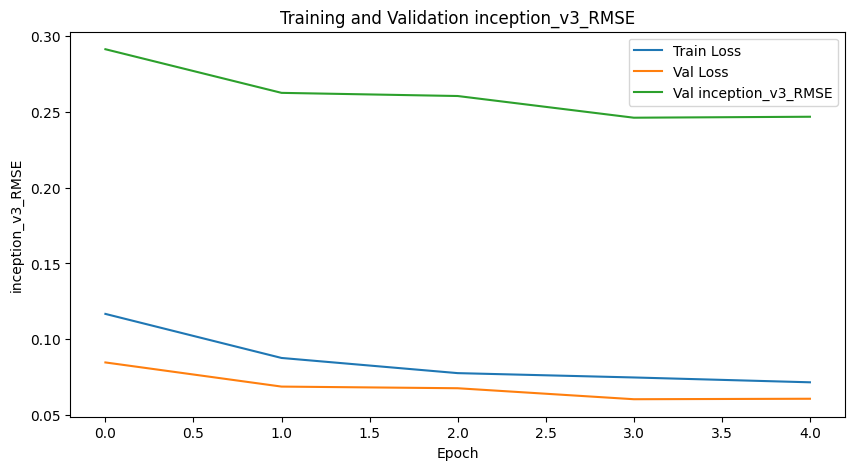

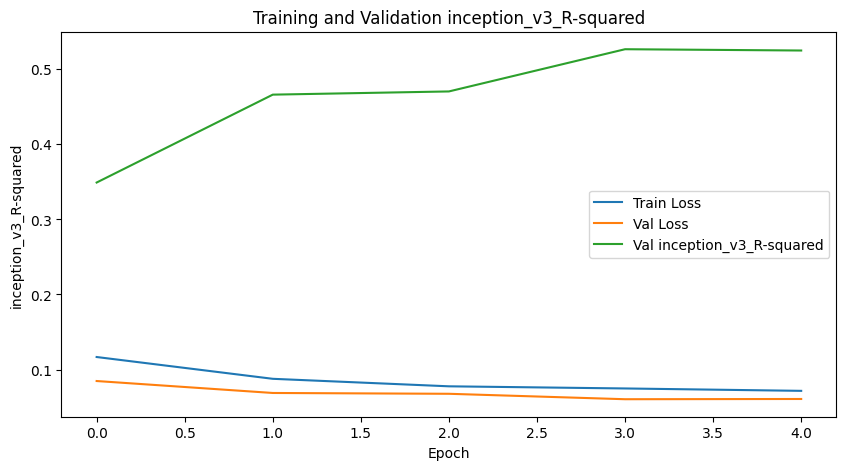

Iteration [1], Params: {'learning_rate': 0.001, 'epochs': 10}
Epoch [1/10], Train Loss: 0.097, Val Loss: 0.063
VAL MSE: 0.063, MAE: 0.188, RMSE: 0.251, R-squared: 0.509
Epoch [2/10], Train Loss: 0.072, Val Loss: 0.058
VAL MSE: 0.058, MAE: 0.178, RMSE: 0.240, R-squared: 0.548
Epoch [3/10], Train Loss: 0.067, Val Loss: 0.055
VAL MSE: 0.055, MAE: 0.170, RMSE: 0.234, R-squared: 0.570
Epoch [4/10], Train Loss: 0.067, Val Loss: 0.054
VAL MSE: 0.054, MAE: 0.163, RMSE: 0.232, R-squared: 0.573
Epoch [5/10], Train Loss: 0.062, Val Loss: 0.051
VAL MSE: 0.051, MAE: 0.153, RMSE: 0.227, R-squared: 0.596
Epoch [6/10], Train Loss: 0.059, Val Loss: 0.049
VAL MSE: 0.049, MAE: 0.155, RMSE: 0.221, R-squared: 0.617
Epoch [7/10], Train Loss: 0.058, Val Loss: 0.046
VAL MSE: 0.046, MAE: 0.147, RMSE: 0.215, R-squared: 0.635
Epoch [8/10], Train Loss: 0.056, Val Loss: 0.044
VAL MSE: 0.044, MAE: 0.138, RMSE: 0.211, R-squared: 0.648
Epoch [9/10], Train Loss: 0.052, Val Loss: 0.047
VAL MSE: 0.047, MAE: 0.141, RMSE:

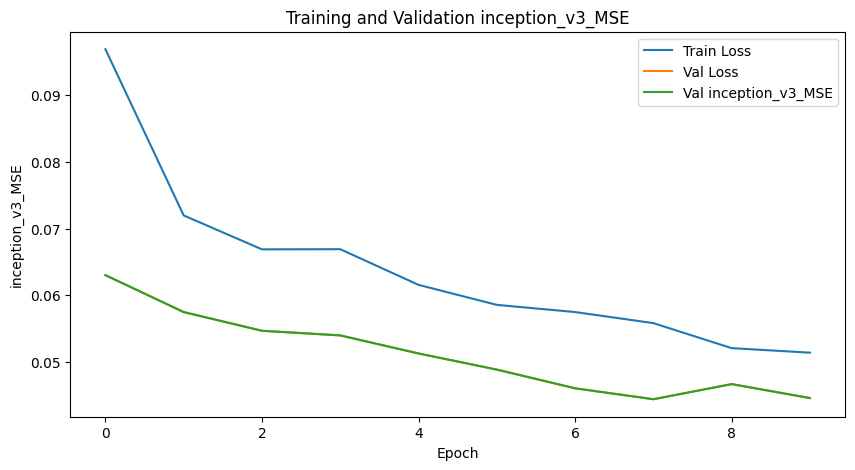

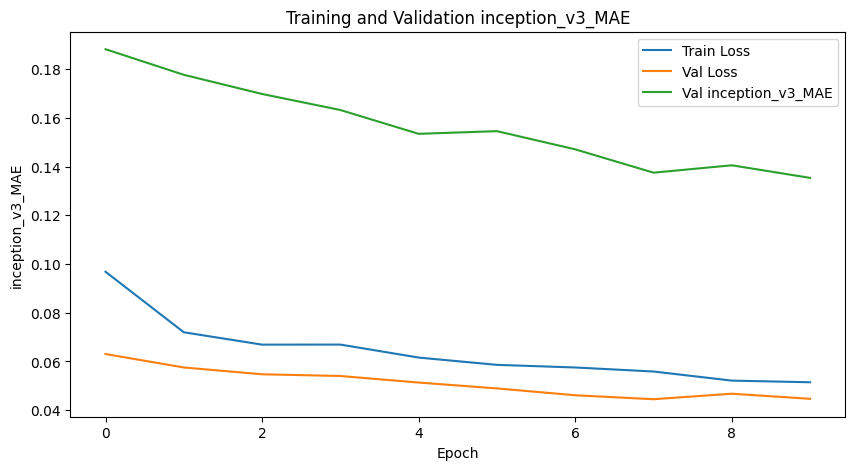

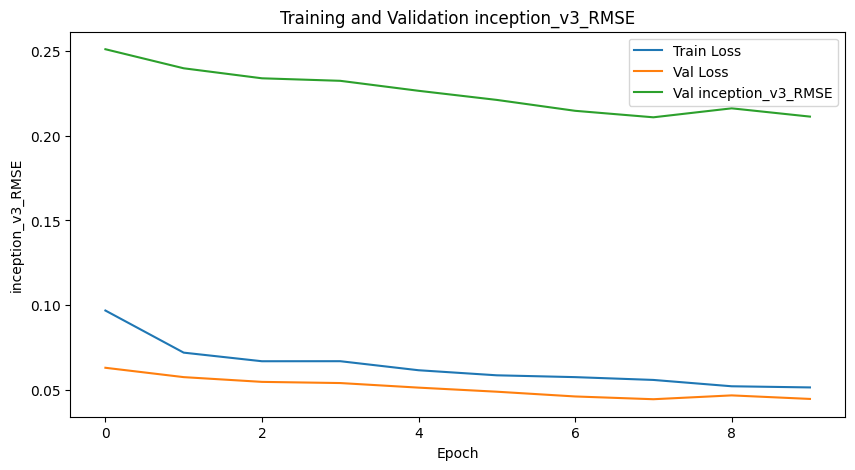

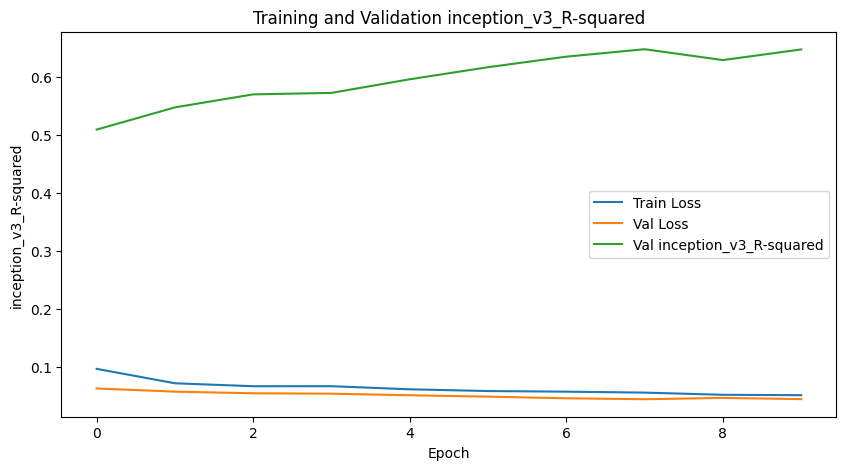

Iteration [2], Params: {'learning_rate': 0.0001, 'epochs': 10}
Epoch [1/10], Train Loss: 0.115, Val Loss: 0.081
VAL MSE: 0.081, MAE: 0.246, RMSE: 0.284, R-squared: 0.381
Epoch [2/10], Train Loss: 0.086, Val Loss: 0.068
VAL MSE: 0.068, MAE: 0.216, RMSE: 0.261, R-squared: 0.470
Epoch [3/10], Train Loss: 0.077, Val Loss: 0.063
VAL MSE: 0.063, MAE: 0.198, RMSE: 0.250, R-squared: 0.512
Epoch [4/10], Train Loss: 0.073, Val Loss: 0.062
VAL MSE: 0.062, MAE: 0.192, RMSE: 0.249, R-squared: 0.516
Epoch [5/10], Train Loss: 0.071, Val Loss: 0.063
VAL MSE: 0.063, MAE: 0.190, RMSE: 0.252, R-squared: 0.502
Epoch [6/10], Train Loss: 0.068, Val Loss: 0.061
VAL MSE: 0.061, MAE: 0.183, RMSE: 0.247, R-squared: 0.522
Epoch [7/10], Train Loss: 0.067, Val Loss: 0.056
VAL MSE: 0.056, MAE: 0.178, RMSE: 0.237, R-squared: 0.558
Epoch [8/10], Train Loss: 0.068, Val Loss: 0.056
VAL MSE: 0.056, MAE: 0.175, RMSE: 0.237, R-squared: 0.557
Epoch [9/10], Train Loss: 0.066, Val Loss: 0.061
VAL MSE: 0.061, MAE: 0.187, RMSE

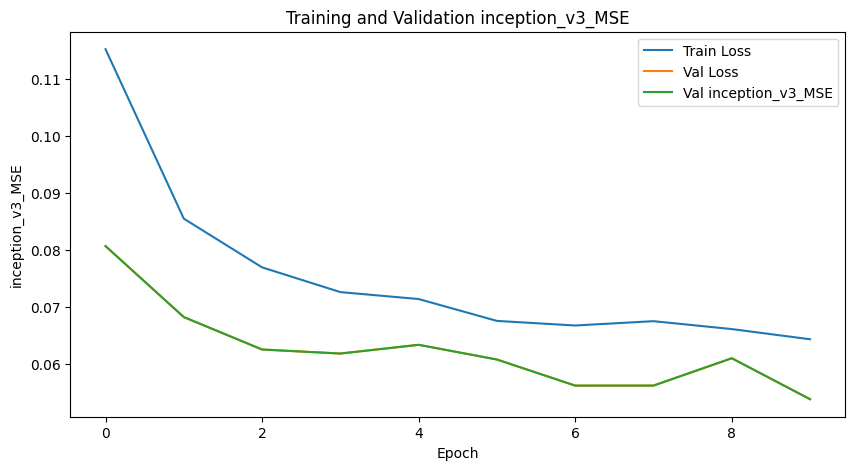

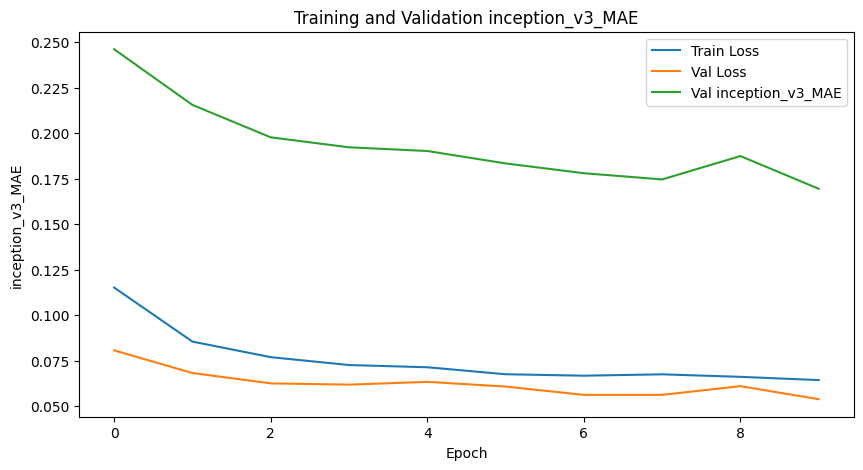

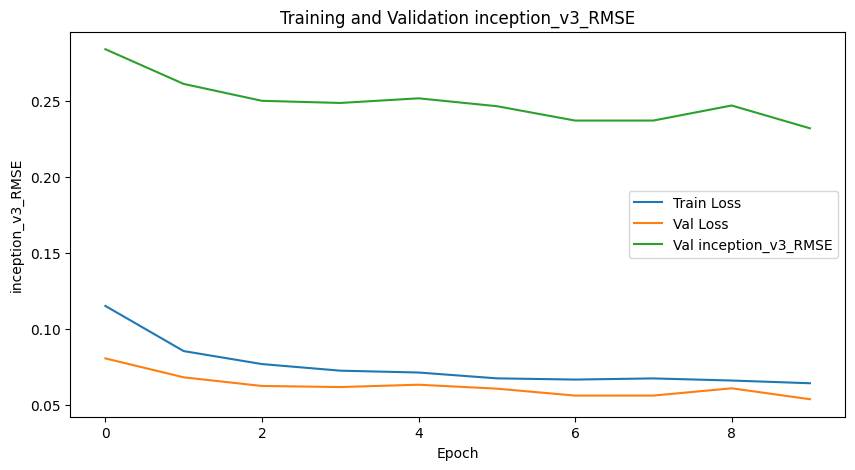

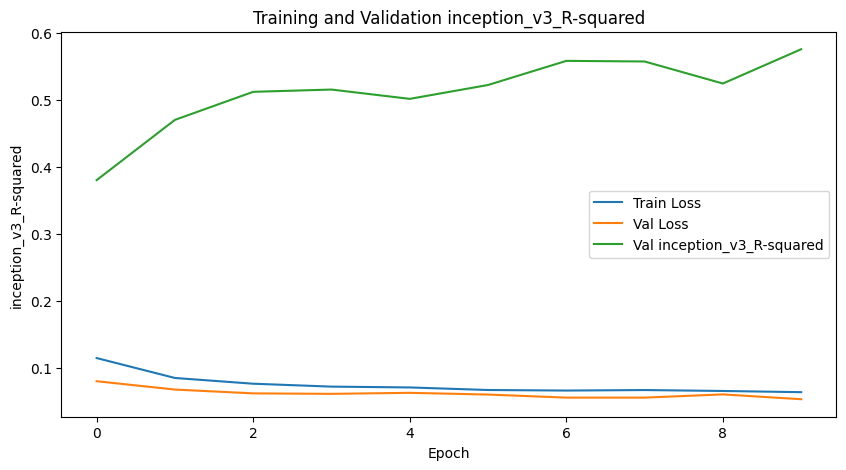

Iteration [3], Params: {'learning_rate': 0.0001, 'epochs': 10}
Epoch [1/10], Train Loss: 0.118, Val Loss: 0.083
VAL MSE: 0.083, MAE: 0.252, RMSE: 0.288, R-squared: 0.364
Epoch [2/10], Train Loss: 0.087, Val Loss: 0.069
VAL MSE: 0.069, MAE: 0.217, RMSE: 0.262, R-squared: 0.466
Epoch [3/10], Train Loss: 0.077, Val Loss: 0.063
VAL MSE: 0.063, MAE: 0.199, RMSE: 0.252, R-squared: 0.507
Epoch [4/10], Train Loss: 0.074, Val Loss: 0.067
VAL MSE: 0.067, MAE: 0.202, RMSE: 0.260, R-squared: 0.470
Epoch [5/10], Train Loss: 0.071, Val Loss: 0.060
VAL MSE: 0.060, MAE: 0.189, RMSE: 0.245, R-squared: 0.530
Epoch [6/10], Train Loss: 0.070, Val Loss: 0.058
VAL MSE: 0.058, MAE: 0.182, RMSE: 0.240, R-squared: 0.547
Epoch [7/10], Train Loss: 0.066, Val Loss: 0.057
VAL MSE: 0.057, MAE: 0.177, RMSE: 0.238, R-squared: 0.554
Epoch [8/10], Train Loss: 0.068, Val Loss: 0.055
VAL MSE: 0.055, MAE: 0.173, RMSE: 0.236, R-squared: 0.563
Epoch [9/10], Train Loss: 0.065, Val Loss: 0.055
VAL MSE: 0.055, MAE: 0.175, RMSE

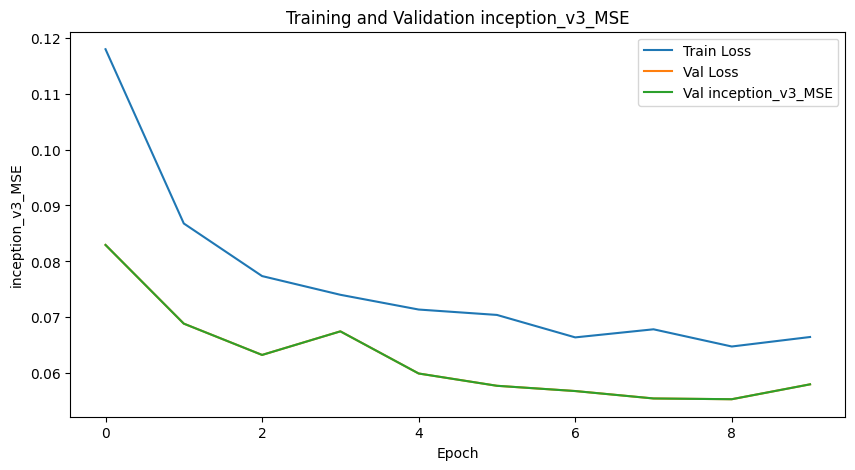

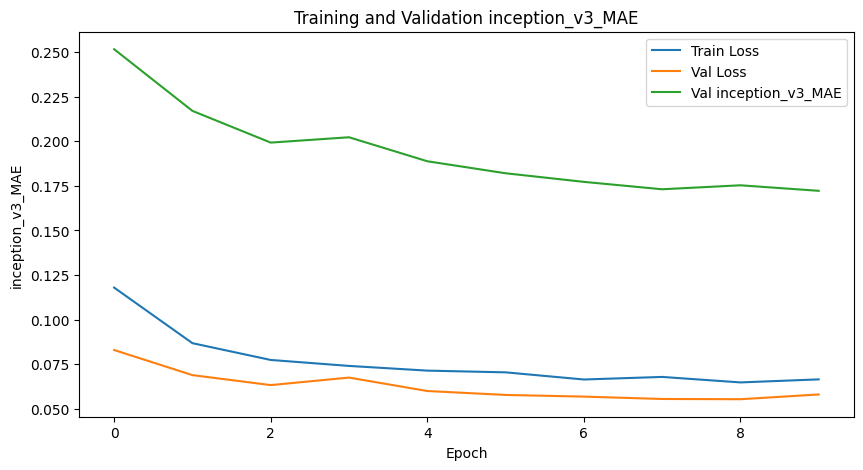

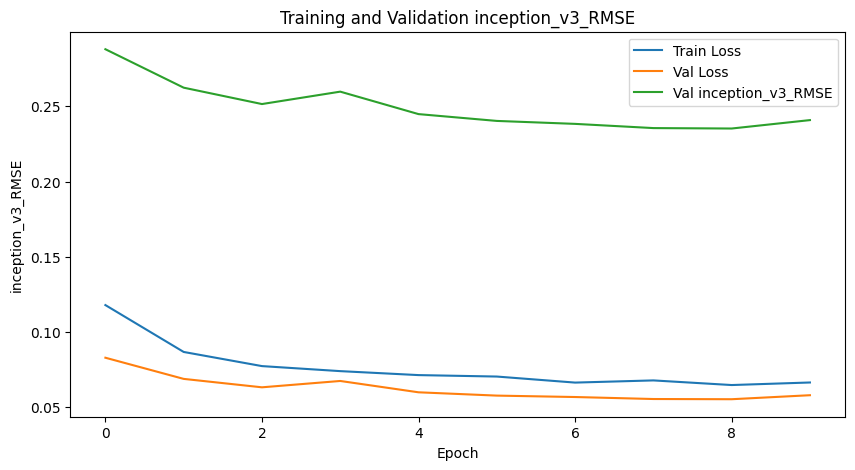

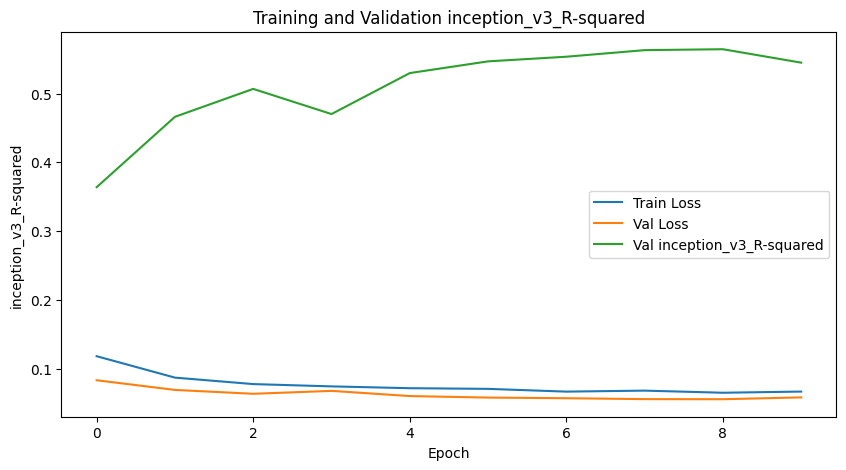

Best model saved with MSE: 0.04463956132531166 at epoch 10 with backbone inception_v3
--------------------------------------------------
[efficientnet_b0]: Start Random Grid Search
Iteration [0], Params: {'learning_rate': 0.0001, 'epochs': 5}
Epoch [1/5], Train Loss: 0.110, Val Loss: 0.076
VAL MSE: 0.076, MAE: 0.234, RMSE: 0.275, R-squared: 0.412
Epoch [2/5], Train Loss: 0.077, Val Loss: 0.063
VAL MSE: 0.063, MAE: 0.200, RMSE: 0.250, R-squared: 0.511
Epoch [3/5], Train Loss: 0.069, Val Loss: 0.058
VAL MSE: 0.058, MAE: 0.183, RMSE: 0.240, R-squared: 0.549
Epoch [4/5], Train Loss: 0.064, Val Loss: 0.057
VAL MSE: 0.057, MAE: 0.180, RMSE: 0.240, R-squared: 0.549
Epoch [5/5], Train Loss: 0.060, Val Loss: 0.056
VAL MSE: 0.056, MAE: 0.177, RMSE: 0.236, R-squared: 0.561
Finished Training


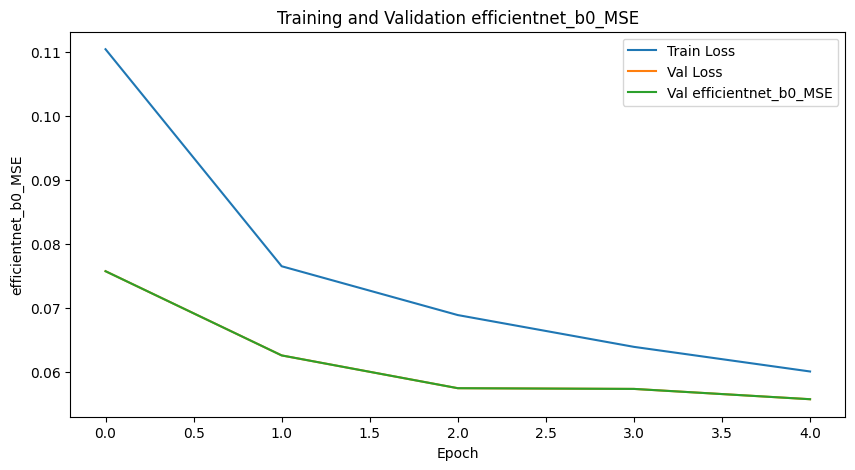

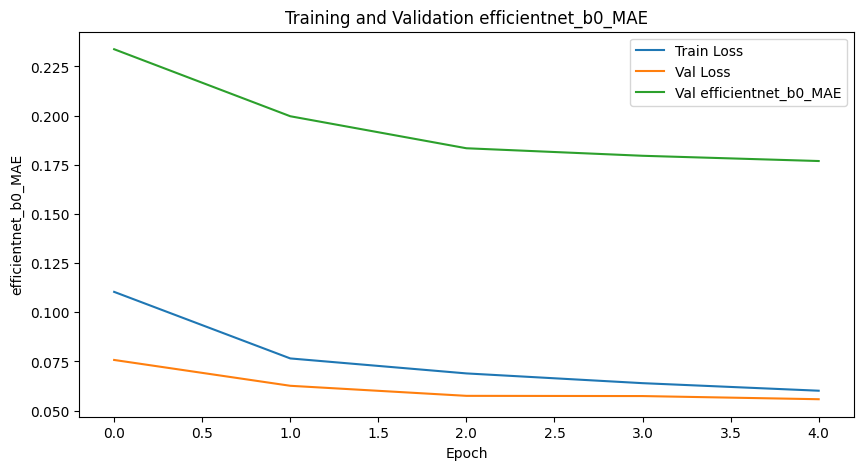

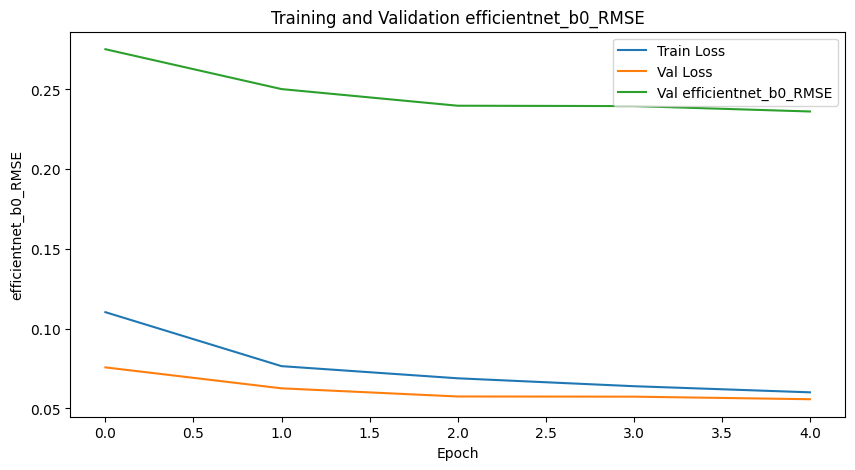

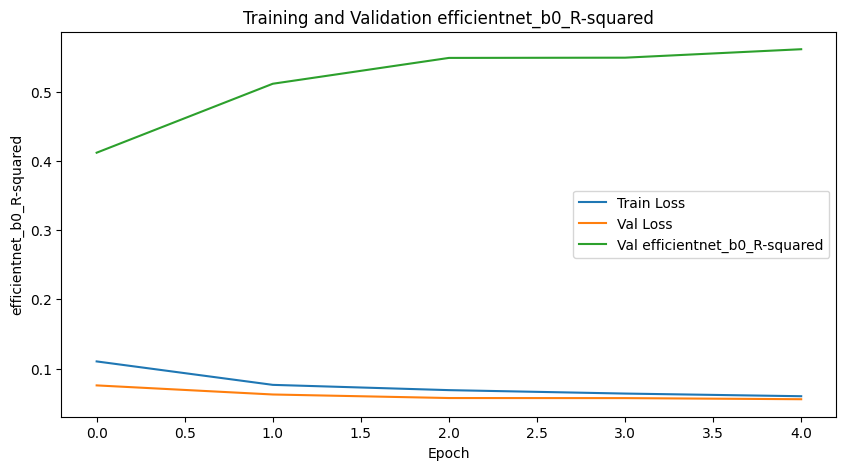

Iteration [1], Params: {'learning_rate': 0.0001, 'epochs': 5}
Epoch [1/5], Train Loss: 0.109, Val Loss: 0.072
VAL MSE: 0.072, MAE: 0.227, RMSE: 0.269, R-squared: 0.438
Epoch [2/5], Train Loss: 0.073, Val Loss: 0.062
VAL MSE: 0.062, MAE: 0.195, RMSE: 0.249, R-squared: 0.515
Epoch [3/5], Train Loss: 0.068, Val Loss: 0.060
VAL MSE: 0.060, MAE: 0.192, RMSE: 0.245, R-squared: 0.529
Epoch [4/5], Train Loss: 0.064, Val Loss: 0.057
VAL MSE: 0.057, MAE: 0.179, RMSE: 0.238, R-squared: 0.554
Epoch [5/5], Train Loss: 0.060, Val Loss: 0.056
VAL MSE: 0.056, MAE: 0.176, RMSE: 0.237, R-squared: 0.558
Finished Training


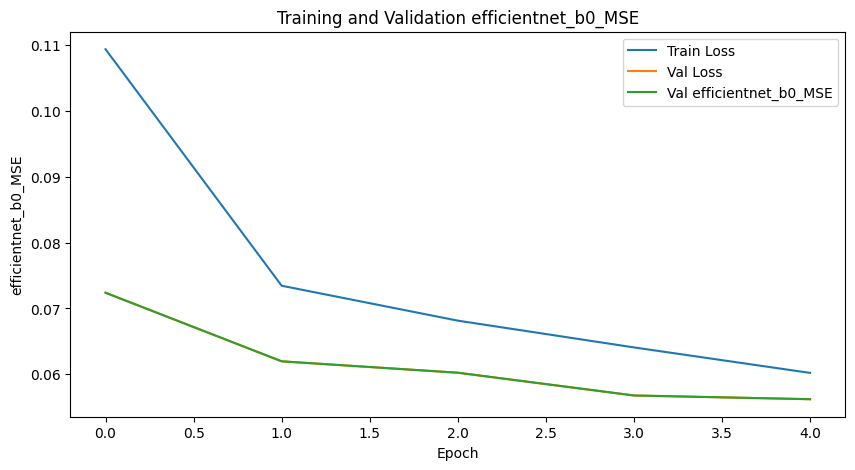

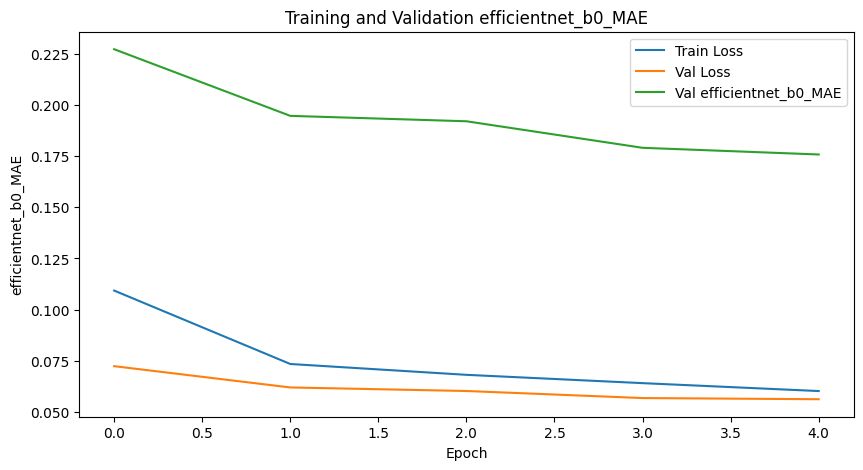

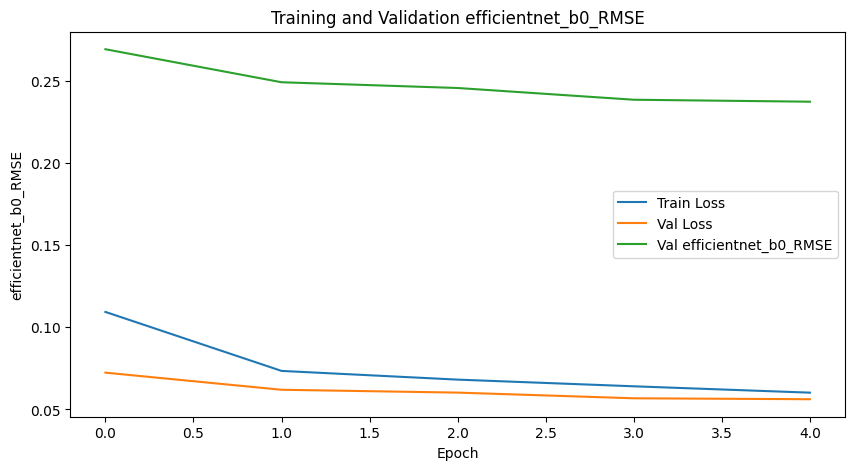

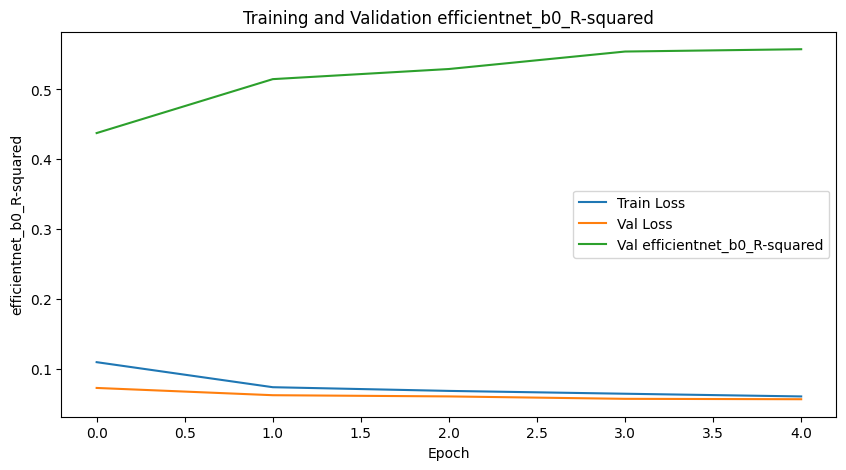

Iteration [2], Params: {'learning_rate': 0.0001, 'epochs': 10}
Epoch [1/10], Train Loss: 0.108, Val Loss: 0.072
VAL MSE: 0.072, MAE: 0.226, RMSE: 0.268, R-squared: 0.441
Epoch [2/10], Train Loss: 0.075, Val Loss: 0.066
VAL MSE: 0.066, MAE: 0.207, RMSE: 0.257, R-squared: 0.486
Epoch [3/10], Train Loss: 0.068, Val Loss: 0.059
VAL MSE: 0.059, MAE: 0.187, RMSE: 0.243, R-squared: 0.539
Epoch [4/10], Train Loss: 0.063, Val Loss: 0.056
VAL MSE: 0.056, MAE: 0.178, RMSE: 0.237, R-squared: 0.558
Epoch [5/10], Train Loss: 0.060, Val Loss: 0.056
VAL MSE: 0.056, MAE: 0.175, RMSE: 0.236, R-squared: 0.561
Epoch [6/10], Train Loss: 0.059, Val Loss: 0.054
VAL MSE: 0.054, MAE: 0.173, RMSE: 0.233, R-squared: 0.572
Epoch [7/10], Train Loss: 0.056, Val Loss: 0.054
VAL MSE: 0.054, MAE: 0.171, RMSE: 0.233, R-squared: 0.570
Epoch [8/10], Train Loss: 0.054, Val Loss: 0.051
VAL MSE: 0.051, MAE: 0.165, RMSE: 0.227, R-squared: 0.595
Epoch [9/10], Train Loss: 0.053, Val Loss: 0.051
VAL MSE: 0.051, MAE: 0.161, RMSE

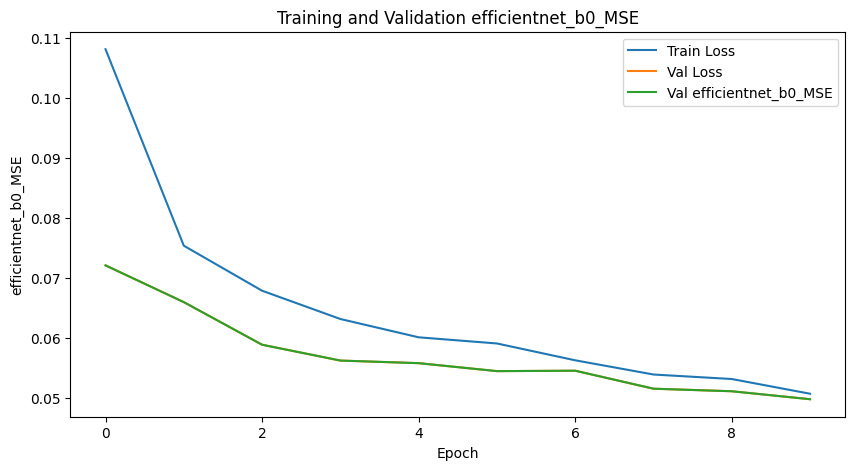

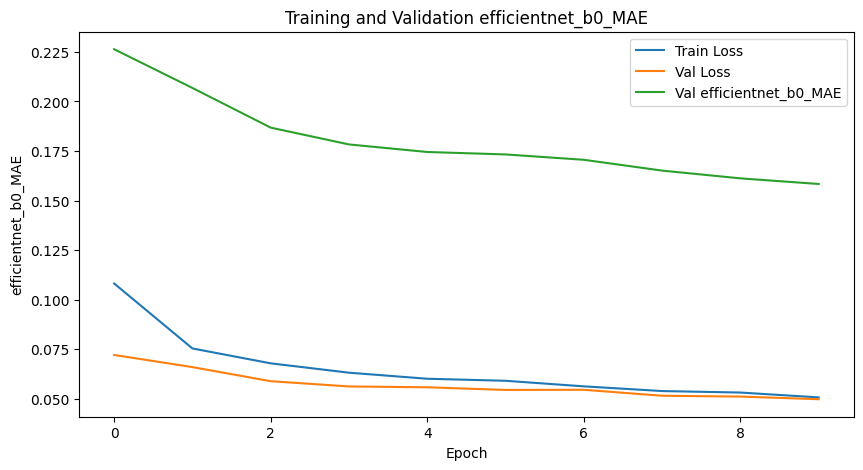

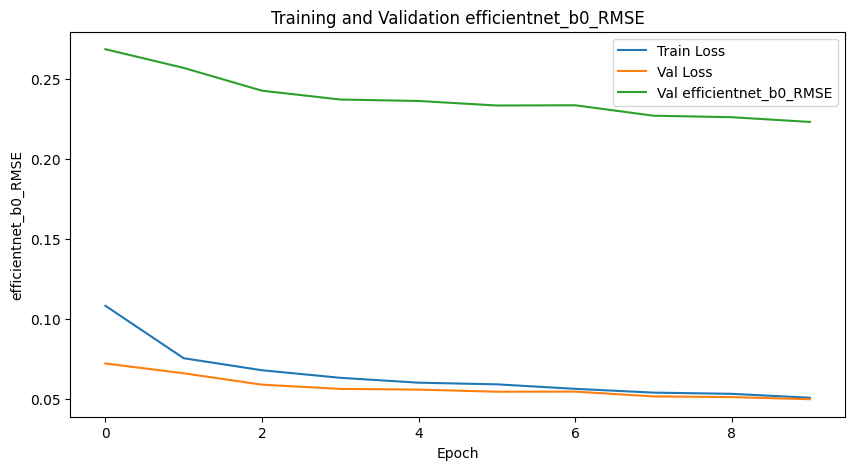

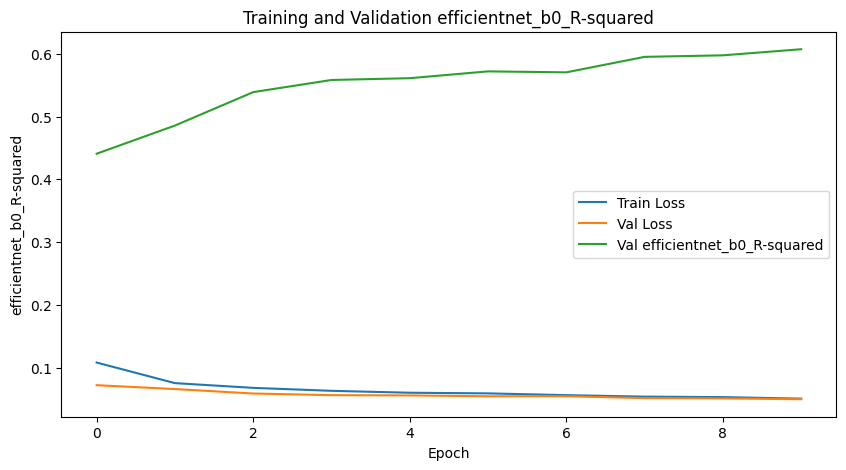

Iteration [3], Params: {'learning_rate': 0.0001, 'epochs': 10}
Epoch [1/10], Train Loss: 0.109, Val Loss: 0.074
VAL MSE: 0.074, MAE: 0.231, RMSE: 0.273, R-squared: 0.423
Epoch [2/10], Train Loss: 0.076, Val Loss: 0.063
VAL MSE: 0.063, MAE: 0.201, RMSE: 0.252, R-squared: 0.506
Epoch [3/10], Train Loss: 0.067, Val Loss: 0.058
VAL MSE: 0.058, MAE: 0.182, RMSE: 0.241, R-squared: 0.543
Epoch [4/10], Train Loss: 0.063, Val Loss: 0.057
VAL MSE: 0.057, MAE: 0.178, RMSE: 0.238, R-squared: 0.554
Epoch [5/10], Train Loss: 0.060, Val Loss: 0.057
VAL MSE: 0.057, MAE: 0.176, RMSE: 0.239, R-squared: 0.551
Epoch [6/10], Train Loss: 0.058, Val Loss: 0.055
VAL MSE: 0.055, MAE: 0.174, RMSE: 0.235, R-squared: 0.565
Epoch [7/10], Train Loss: 0.055, Val Loss: 0.055
VAL MSE: 0.055, MAE: 0.171, RMSE: 0.234, R-squared: 0.570
Epoch [8/10], Train Loss: 0.053, Val Loss: 0.051
VAL MSE: 0.051, MAE: 0.161, RMSE: 0.225, R-squared: 0.599
Epoch [9/10], Train Loss: 0.051, Val Loss: 0.051
VAL MSE: 0.051, MAE: 0.161, RMSE

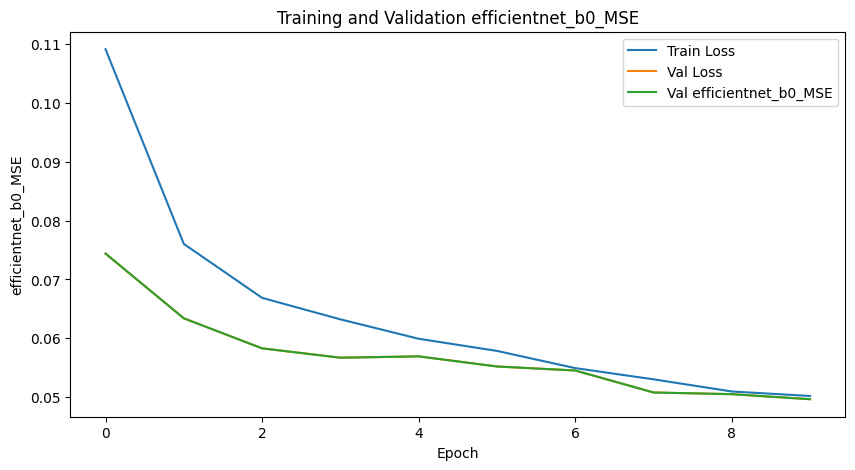

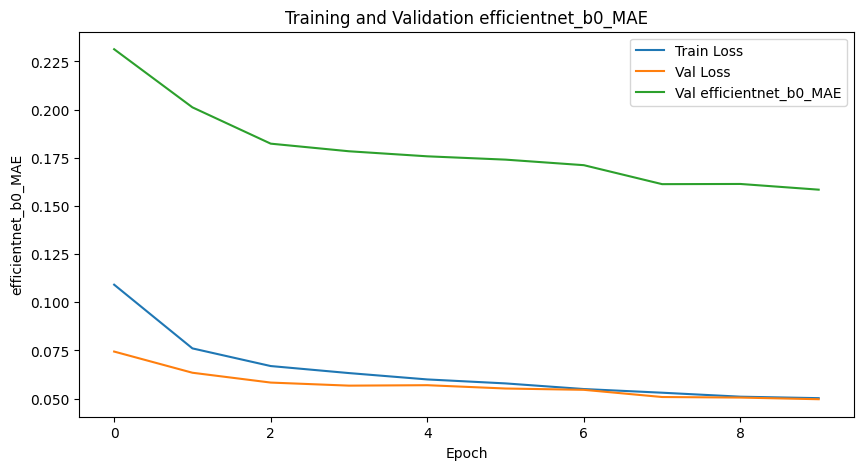

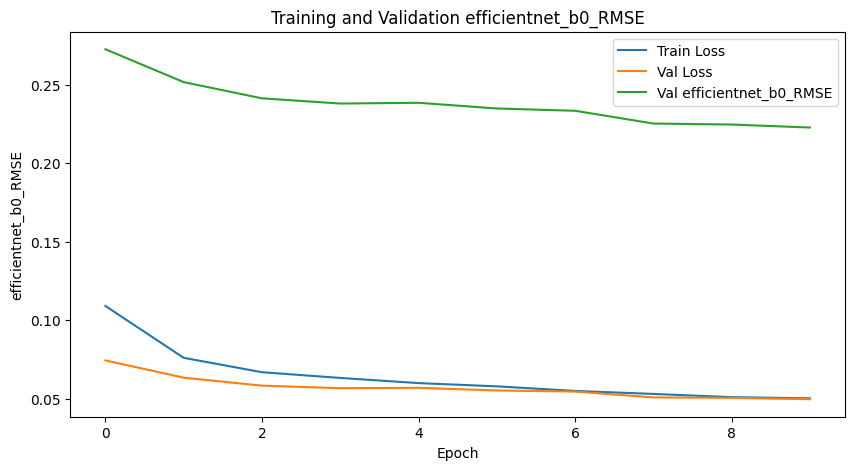

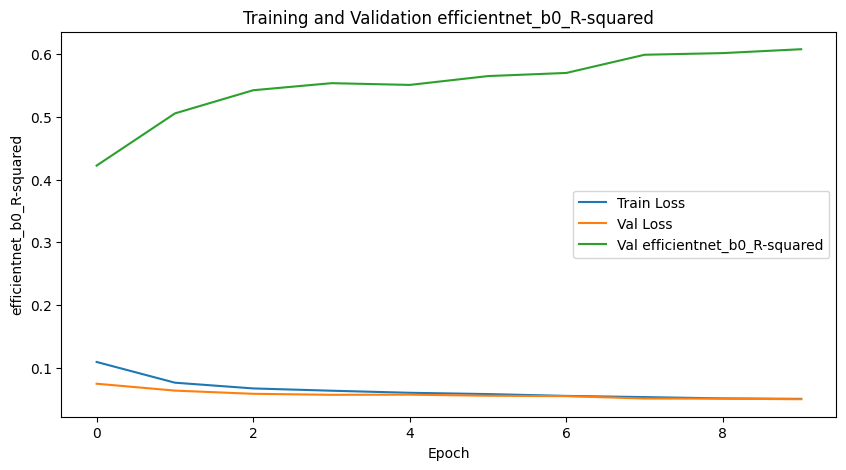

Best model saved with MSE: 0.0496549978852272 at epoch 10 with backbone efficientnet_b0
--------------------------------------------------


In [34]:
# Define grid search space
backbones = ['resnet18', 'inception_v3', 'efficientnet_b0']

for backbone in backbones:
    grid_params = {
        'learning_rate': [0.001, 0.0001],
        'epochs': [5, 10]
    }

    # Perform random grid search
    num_iterations = 4
    best_model, best_mse, best_epoch = random_grid_search(backbone, grid_params, num_iterations, train_loader, val_loader)

    # Save the best model
    torch.save(best_model.state_dict(), backbone+'_best_model.pth')
    print(f'Best model saved with MSE: {best_mse} at epoch {best_epoch} with backbone {backbone}')
    print("-" * 50)

[vit_b_16]: Start Random Grid Search
Iteration [0], Params: {'learning_rate': 0.001, 'epochs': 10}
Epoch [1/10], Train Loss: 0.073, Val Loss: 0.050
VAL MSE: 0.050, MAE: 0.158, RMSE: 0.224, R-squared: 0.602
Epoch [2/10], Train Loss: 0.052, Val Loss: 0.048
VAL MSE: 0.048, MAE: 0.153, RMSE: 0.220, R-squared: 0.617
Epoch [3/10], Train Loss: 0.047, Val Loss: 0.045
VAL MSE: 0.045, MAE: 0.137, RMSE: 0.213, R-squared: 0.638
Epoch [4/10], Train Loss: 0.040, Val Loss: 0.044
VAL MSE: 0.044, MAE: 0.136, RMSE: 0.211, R-squared: 0.647
Epoch [5/10], Train Loss: 0.036, Val Loss: 0.042
VAL MSE: 0.042, MAE: 0.128, RMSE: 0.205, R-squared: 0.663
Epoch [6/10], Train Loss: 0.033, Val Loss: 0.042
VAL MSE: 0.042, MAE: 0.126, RMSE: 0.206, R-squared: 0.661
Epoch [7/10], Train Loss: 0.028, Val Loss: 0.043
VAL MSE: 0.043, MAE: 0.124, RMSE: 0.207, R-squared: 0.655
Epoch [8/10], Train Loss: 0.025, Val Loss: 0.044
VAL MSE: 0.044, MAE: 0.119, RMSE: 0.210, R-squared: 0.644
Epoch [9/10], Train Loss: 0.021, Val Loss: 0.

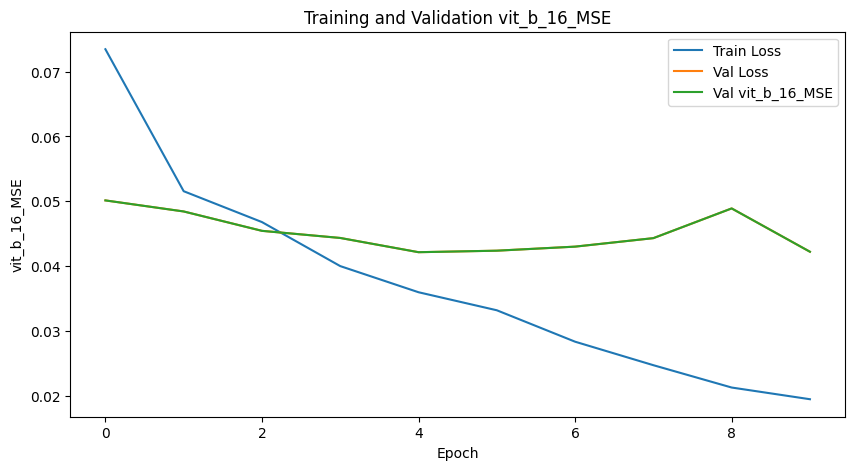

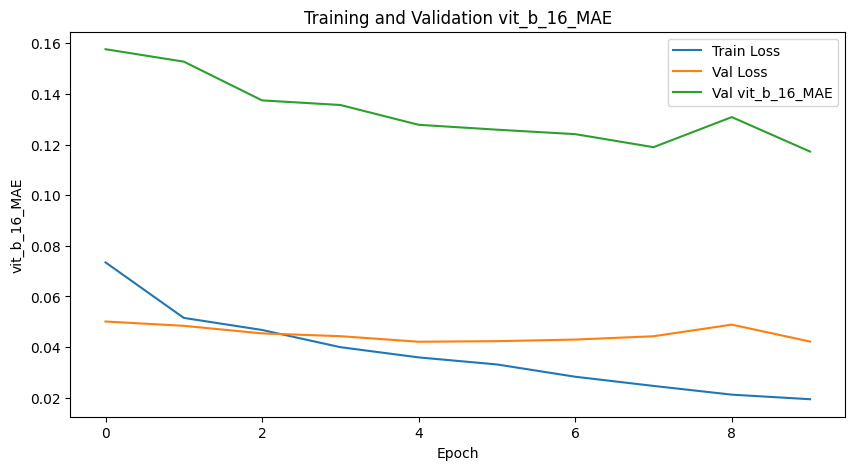

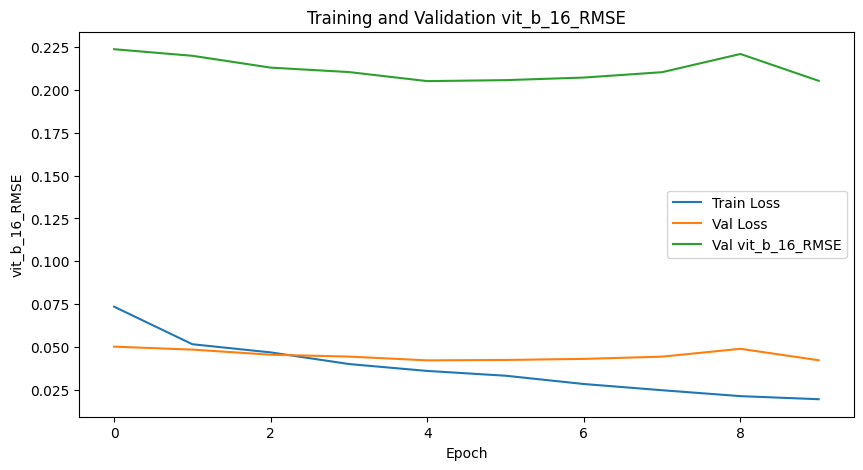

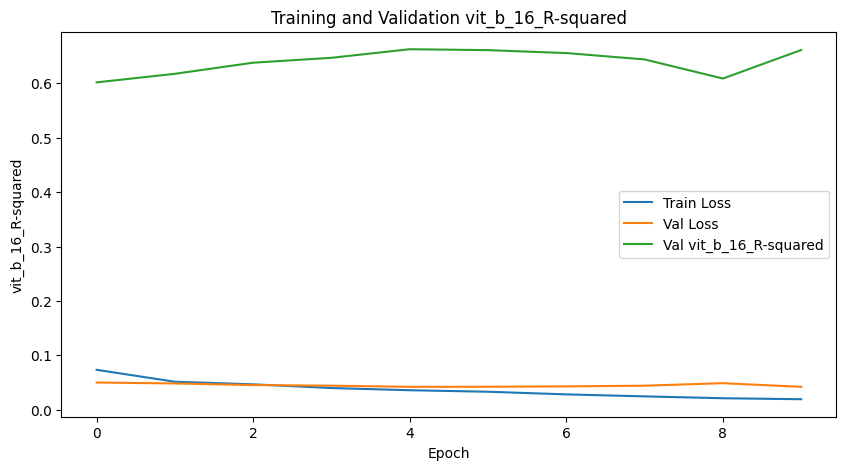

Iteration [1], Params: {'learning_rate': 0.001, 'epochs': 5}
Epoch [1/5], Train Loss: 0.070, Val Loss: 0.067
VAL MSE: 0.067, MAE: 0.186, RMSE: 0.258, R-squared: 0.470
Epoch [2/5], Train Loss: 0.051, Val Loss: 0.045
VAL MSE: 0.045, MAE: 0.142, RMSE: 0.212, R-squared: 0.640
Epoch [3/5], Train Loss: 0.046, Val Loss: 0.046
VAL MSE: 0.046, MAE: 0.140, RMSE: 0.215, R-squared: 0.630
Epoch [4/5], Train Loss: 0.040, Val Loss: 0.046
VAL MSE: 0.046, MAE: 0.137, RMSE: 0.215, R-squared: 0.632
Epoch [5/5], Train Loss: 0.036, Val Loss: 0.046
VAL MSE: 0.046, MAE: 0.131, RMSE: 0.216, R-squared: 0.627
Finished Training


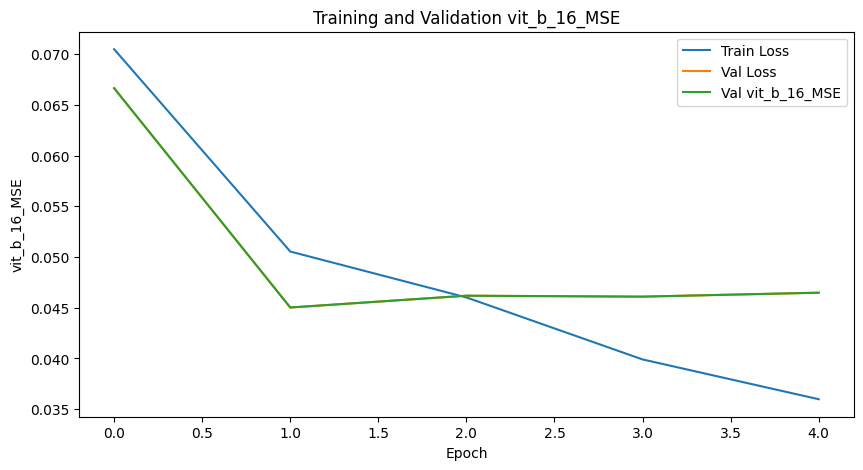

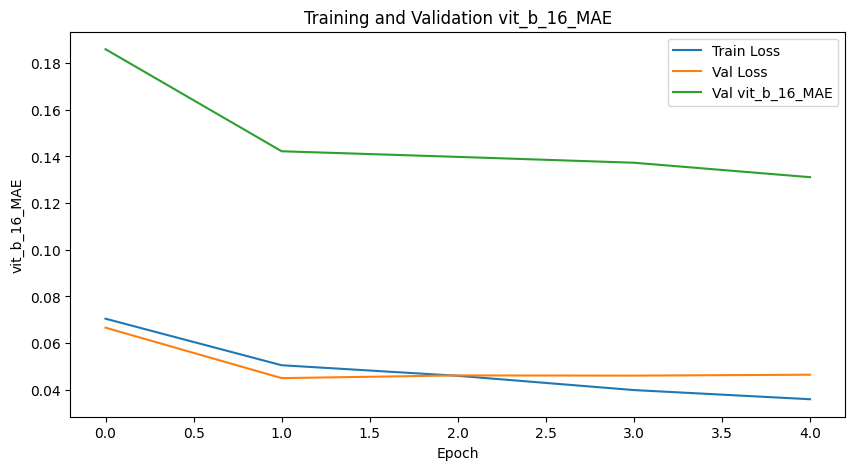

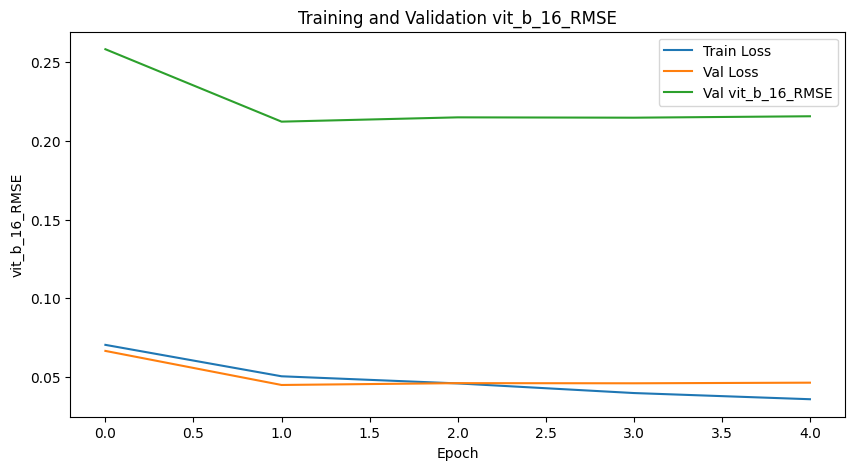

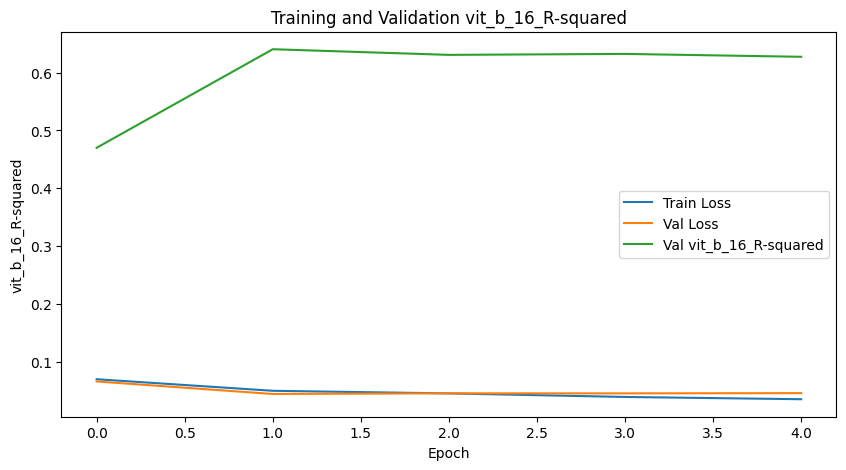

Iteration [2], Params: {'learning_rate': 0.001, 'epochs': 10}
Epoch [1/10], Train Loss: 0.071, Val Loss: 0.049
VAL MSE: 0.049, MAE: 0.158, RMSE: 0.221, R-squared: 0.610
Epoch [2/10], Train Loss: 0.051, Val Loss: 0.047
VAL MSE: 0.047, MAE: 0.143, RMSE: 0.216, R-squared: 0.626
Epoch [3/10], Train Loss: 0.044, Val Loss: 0.045
VAL MSE: 0.045, MAE: 0.137, RMSE: 0.212, R-squared: 0.641
Epoch [4/10], Train Loss: 0.039, Val Loss: 0.047
VAL MSE: 0.047, MAE: 0.140, RMSE: 0.216, R-squared: 0.625
Epoch [5/10], Train Loss: 0.036, Val Loss: 0.043
VAL MSE: 0.043, MAE: 0.132, RMSE: 0.207, R-squared: 0.658
Epoch [6/10], Train Loss: 0.031, Val Loss: 0.045
VAL MSE: 0.045, MAE: 0.126, RMSE: 0.213, R-squared: 0.637
Epoch [7/10], Train Loss: 0.028, Val Loss: 0.048
VAL MSE: 0.048, MAE: 0.125, RMSE: 0.219, R-squared: 0.616
Epoch [8/10], Train Loss: 0.025, Val Loss: 0.048
VAL MSE: 0.048, MAE: 0.128, RMSE: 0.219, R-squared: 0.616
Epoch [9/10], Train Loss: 0.023, Val Loss: 0.043
VAL MSE: 0.043, MAE: 0.123, RMSE:

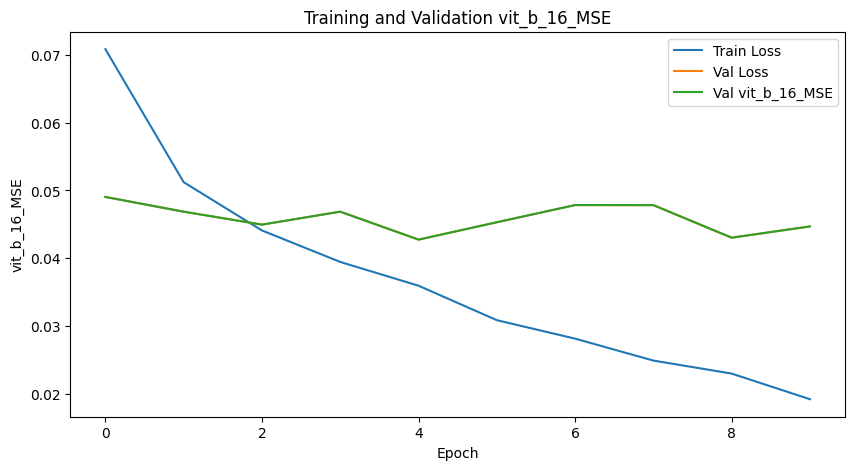

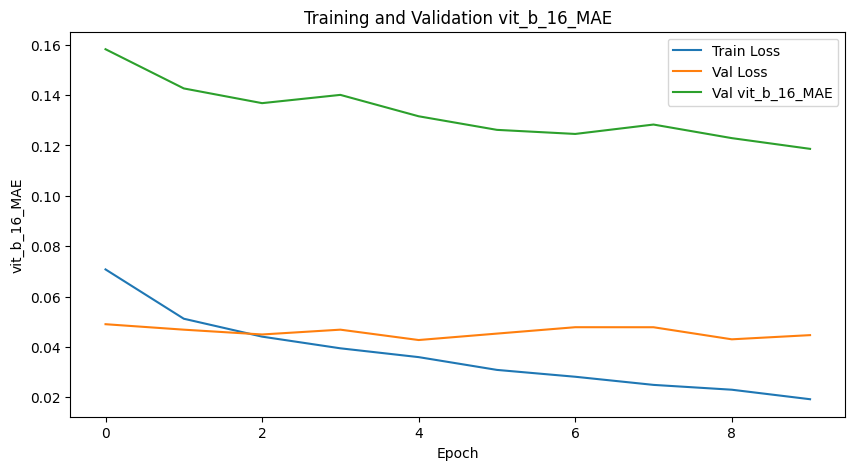

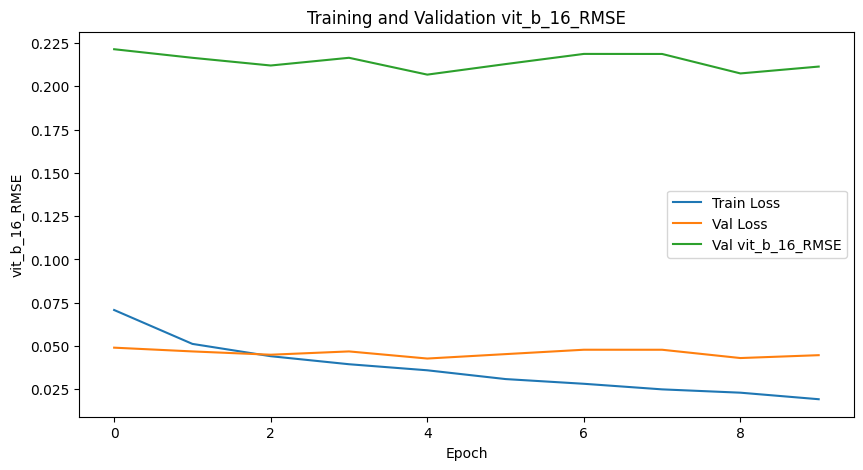

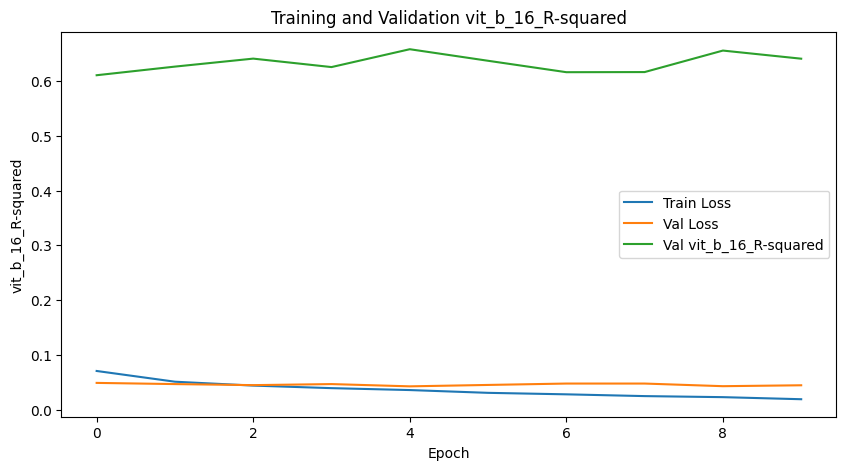

Iteration [3], Params: {'learning_rate': 0.0001, 'epochs': 10}
Epoch [1/10], Train Loss: 0.102, Val Loss: 0.069
VAL MSE: 0.069, MAE: 0.217, RMSE: 0.263, R-squared: 0.465
Epoch [2/10], Train Loss: 0.068, Val Loss: 0.057
VAL MSE: 0.057, MAE: 0.189, RMSE: 0.239, R-squared: 0.551
Epoch [3/10], Train Loss: 0.059, Val Loss: 0.052
VAL MSE: 0.052, MAE: 0.174, RMSE: 0.228, R-squared: 0.587
Epoch [4/10], Train Loss: 0.054, Val Loss: 0.050
VAL MSE: 0.050, MAE: 0.166, RMSE: 0.223, R-squared: 0.606
Epoch [5/10], Train Loss: 0.051, Val Loss: 0.049
VAL MSE: 0.049, MAE: 0.161, RMSE: 0.222, R-squared: 0.607
Epoch [6/10], Train Loss: 0.048, Val Loss: 0.047
VAL MSE: 0.047, MAE: 0.154, RMSE: 0.216, R-squared: 0.627
Epoch [7/10], Train Loss: 0.046, Val Loss: 0.046
VAL MSE: 0.046, MAE: 0.152, RMSE: 0.215, R-squared: 0.631
Epoch [8/10], Train Loss: 0.044, Val Loss: 0.045
VAL MSE: 0.045, MAE: 0.148, RMSE: 0.213, R-squared: 0.639
Epoch [9/10], Train Loss: 0.042, Val Loss: 0.047
VAL MSE: 0.047, MAE: 0.148, RMSE

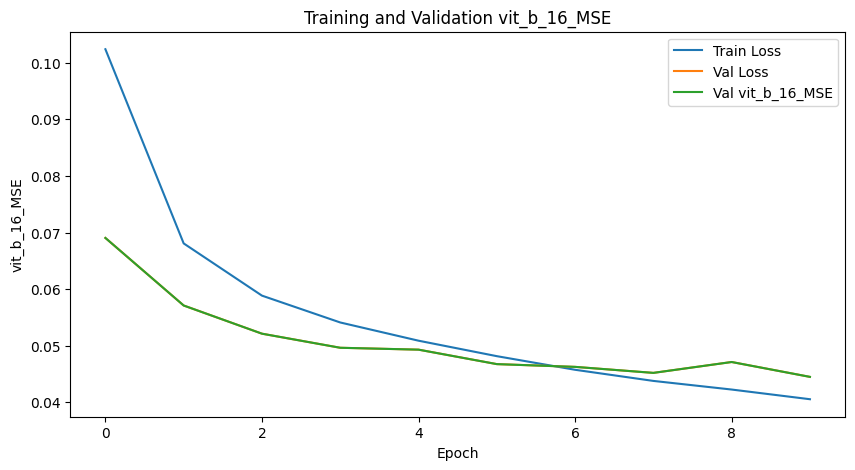

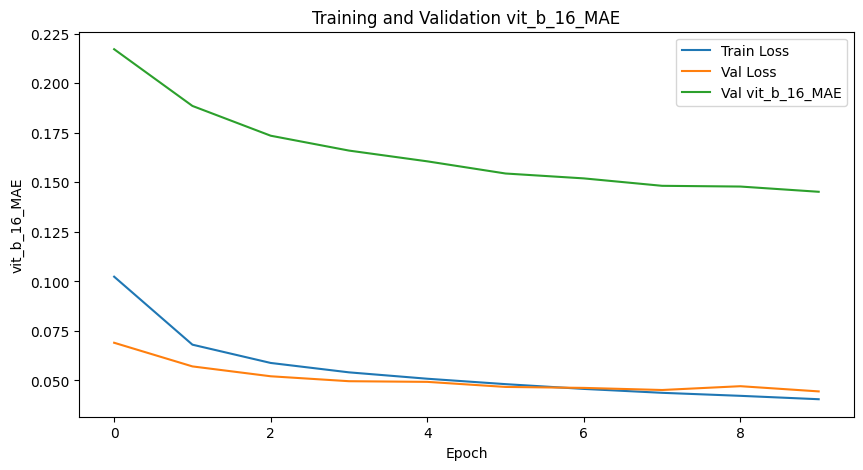

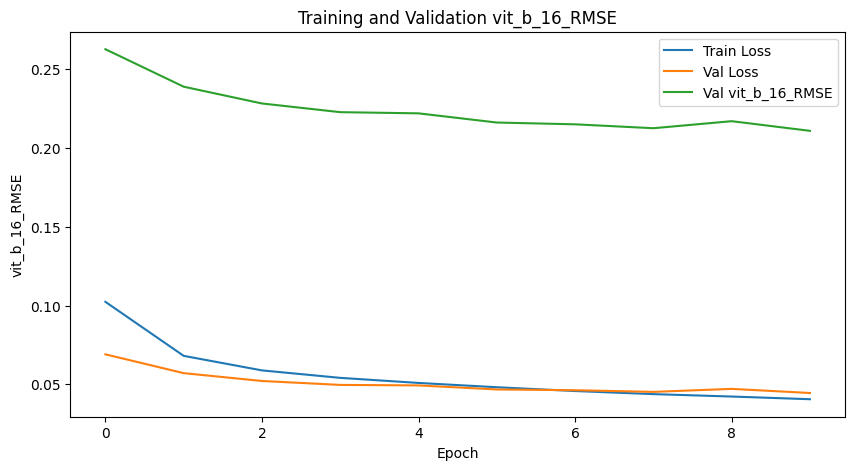

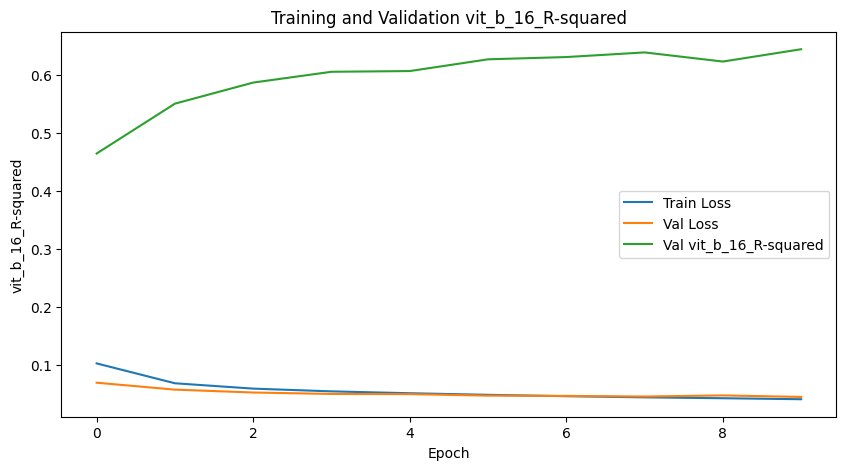

Best model saved with MSE: 0.04219449311494827 at epoch 10 with backbone vit_b_16
--------------------------------------------------


In [36]:
backbones = ['vit_b_16']

for backbone in backbones:
    grid_params = {
        'learning_rate': [0.001, 0.0001],
        'epochs': [5, 10]
    }

    # Perform random grid search
    num_iterations = 4
    best_model, best_mse, best_epoch = random_grid_search(backbone, grid_params, num_iterations, train_loader, val_loader)

    # Save the best model
    torch.save(best_model.state_dict(), backbone+'_best_model.pth')
    print(f'Best model saved with MSE: {best_mse} at epoch {best_epoch} with backbone {backbone}')
    print("-" * 50)

<h3>Analyse / Insights</h3>
<ul>
  <li><b> MSE, MAE, and RMSE Trends:</b>
MSE, MAE, and RMSE generally decrease over epochs for both training and validation sets. This indicates that the model is learning from the data and improving its predictive accuracy over time.<br>
The decreasing trend suggests that the model is converging towards a solution and becoming more accurate in its predictions.</li>
  <li><b>R-squared Trends:</b>
R-squared values increase over epochs for both training and validation sets. This indicates that the model's fit to the data improves over time.
Higher R-squared values on the validation set suggest that the model is generalizing well to unseen data, while R-squared values on the training set approaching 1 indicate that the model is fitting the training data well.</li>
  <li><b>Comparison Between Training and Validation:</b>
Ideally, we want to see similar trends in MSE, MAE, RMSE, and R-squared for both training and validation sets, indicating that the model is not overfitting or underfitting.
If there's a significant gap between training and validation metrics, it may indicate overfitting (if training metrics are much lower than validation metrics) or underfitting (if both training and validation metrics are high).</li>
</ul>
